In [169]:
#import necessary libraries
import os
from collections import Counter
import cv2
import numpy as np
import pandas as pd
import random
import math
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
import albumentations as A
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import cv2
from skimage.feature import local_binary_pattern, hog
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage.feature import local_binary_pattern, hog
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## Explanation: Declare Variables, Create Augmented Folder, and Delete Existing Augmented Files

This code block performs the following steps:

1. **Declare Variables**:
    - `dataset_path`: The root directory where your dataset is stored.
    - `classes`: A list of class names (categories) in your dataset.
    - `img_size`: The target size (width, height) for images.
    - `target_size`: The desired number of images per class after augmentation.

2. **Create Augmented Folder for Each Class**:
    - For each class in `classes`, it constructs the path to an `augmented` subfolder inside the class directory.
    - If the `augmented` folder does not exist, it is created using `mkdir(parents=True, exist_ok=True)`.

3. **Delete All Existing Files in Augmented Folders**:
    - Iterates through all files in each `augmented` folder.
    - If a file is found, it is deleted using `unlink()`.
    - This ensures that the augmented folders are empty before new augmented images are generated.

In [182]:
#declare variables, Create augmented folder and delete Delete all existing augmented files inside augmented directories
dataset_path = "../dataset"
classes = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]
img_size = (128, 128)
target_size=700
#delete existing augmented files
dataset_path = Path(dataset_path)  # make sure it's a Path object

for cls in classes:
    aug_dir = dataset_path  / cls/ "augmented"

    # Create folder if not exists
    aug_dir.mkdir(parents=True, exist_ok=True)

    # Delete all existing files inside
    for file in aug_dir.iterdir():
        if file.is_file():
            file.unlink()

## Explanation: split dataset into train and test sets


In [171]:
# split dataset into train and test sets
all_files = []
all_labels = []

for idx, cls in enumerate(classes):
    class_folder = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_folder):
        print(f"Warning: Folder not found: {class_folder}")
        continue

    for f in os.listdir(class_folder):
        if not (f.endswith(".jpg") or f.endswith(".png")):
            continue
        file_path = os.path.join(class_folder, f)

        img = cv2.imread(file_path)
        if img is None:
            print(f"Warning: Cannot open image {file_path}, skipping.")
            continue

        all_files.append(file_path)
        all_labels.append(idx)

train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.2,shuffle=True, stratify=all_labels
)

print(f"Train: {len(train_files)} images")
print(f"Test: {len(test_files)} images")

Train: 1492 images
Test: 373 images


# Image Augmentation Pipeline Explanation

This code defines an image augmentation pipeline using the **Albumentations** library.

---
## varible 
p is the probability to use this filtter and
n is the number of filtter that will choose randmly on each image


## Randomness for Different Results
To ensure each input image gets **different random augmentations every time**, we reset the random seeds:

```python
random.seed(None)
np.random.seed(None)



In [172]:
# Define augmentation pipeline
random.seed(None)
np.random.seed(None)

transform = A.Compose([
    A.SomeOf([
        A.HorizontalFlip(p=0.7),
        A.VerticalFlip(p=.7),
        A.Rotate(limit=45, p=.7),
        A.Rotate(limit=90, p=.7),
        A.RandomScale(scale_limit=0.2, p=.2),
        A.CenterCrop(width=128, height=128, p=.3),  
        A.ColorJitter(p=0.5),
        A.Resize(width=random.randint(img_size[0], 512), height=random.randint(img_size[1], 384), p=.8)
    ], n=3)
])

## Function to perform data augmentation

In [173]:
# Function to perform data augmentation
def data_autgmentation(img_path, output_folder, aug_times):
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    if img is None:
        print(f"ERROR: Cannot load image {img_path}. Skipping.")
        return
    for i in range(aug_times):
        augmented = transform(image=img)
        aug_img = augmented["image"]
        aug_img_name = f"{os.path.splitext(img_name)[0]}_aug_{i+1}.jpg"
        aug_img_path = os.path.join(output_folder, aug_img_name)
        cv2.imwrite(aug_img_path, aug_img)
    print(f"Augmented {aug_times} images for {img_name}")

In [174]:
# Augment training images by 500 images per class
class_counts = Counter(train_labels)

for cls_idx, cls_name in enumerate(classes):
    
    cls_images = [img for i, img in enumerate(train_files) if train_labels[i] == cls_idx]
    current_count = class_counts[cls_idx]
    aug_needed = max(0, target_size - current_count)
    
    if aug_needed == 0:
        continue
    
    output_folder = os.path.join(dataset_path, cls_name, "augmented")
        
    times_per_image = math.ceil(aug_needed / len(cls_images))
    count=0
    for img_path in tqdm(cls_images, desc=f"Augmenting {cls_name}"):
        if count>= aug_needed:
            break
        data_autgmentation(img_path, output_folder, times_per_image)
        count=count+times_per_image

Augmenting glass:   9%|▉         | 29/308 [00:00<00:01, 142.08it/s]

Augmented 2 images for 9799fc00-ac4f-4a4e-b535-2db8f151f75c.jpg
Augmented 2 images for f7e0d690-b7b6-48b4-9468-655f69a8b4c5.jpg
Augmented 2 images for 76add70e-c0c1-42e9-9131-000e51feaf36.jpg
Augmented 2 images for 8f1ced22-0b30-455e-b7ce-f67da23d2bc7.jpg
Augmented 2 images for 2d944c5e-f66e-425a-91d3-4c00213b12a5.jpg
Augmented 2 images for 185aa5a3-14ef-4cdb-82aa-939901f6809c.jpg
Augmented 2 images for ec7a7502-476f-4bcc-b303-d6fe28986195.jpg
Augmented 2 images for f0e43393-af8f-46d8-8d16-261cf66b4cfc.jpg
Augmented 2 images for ea28b38a-2f21-412e-8c27-2337d53523e3.jpg
Augmented 2 images for a684e2ae-8cae-476b-8ef1-8b350293890b.jpg
Augmented 2 images for 9b17cd29-22bb-4d2c-ace6-adff43e403e2.jpg
Augmented 2 images for 0e4b98a2-abba-414a-8628-9983620da84c.jpg
Augmented 2 images for 4ce6fc9f-9ace-4f88-9a00-7506292e94b9.jpg
Augmented 2 images for 7ecaa2bc-9821-454f-84a0-be63f204d095.jpg
Augmented 2 images for 41c14d2a-0a39-4142-84d4-b3c2bce73c51.jpg
Augmented 2 images for c4359f9e-ea48-411

Augmenting glass:  14%|█▍        | 44/308 [00:00<00:02, 129.93it/s]

Augmented 2 images for 3dcc3ec8-e440-4f18-922b-38b3208e8280.jpg
Augmented 2 images for 9a4e7bc9-cde3-4848-b699-6053c50e30fa.jpg
Augmented 2 images for 89b7d25e-91b0-4f5b-a390-704bb024a37f.jpg
Augmented 2 images for 929697c8-4465-45c7-b9ae-d9d8dae75a0f.jpg
Augmented 2 images for f48ce712-28d0-4b56-897f-9b2490d8056b.jpg
Augmented 2 images for 19219201-0fe8-49c9-9cfb-f262db0a0d46.jpg
Augmented 2 images for 2ef87519-0a5b-4dc1-b054-2857c0426d79.jpg
Augmented 2 images for a9ef4b6f-41db-402f-941a-1a8ec9cd5027.jpg
Augmented 2 images for 222686bf-cf82-4617-b394-ddd10a226081.jpg
Augmented 2 images for 4abf6159-e7f6-4bbb-9176-403459e9124a.jpg
Augmented 2 images for fd36a059-4fc1-4559-9f56-89f0f435ea8f.jpg
Augmented 2 images for bd252172-a40d-46b4-9517-bc8441cfcc90.jpg
Augmented 2 images for becf8ed9-64c4-4501-8b84-ac1083923f5f.jpg
Augmented 2 images for 3f1729d5-174d-43b0-a47c-f63a0755386f.jpg
Augmented 2 images for 01456f8c-78c5-4eb4-aa0c-5f306a61d639.jpg
Augmented 2 images for 0ec28c79-21d2-416

Augmenting glass:  24%|██▎       | 73/308 [00:00<00:01, 133.60it/s]

Augmented 2 images for eb040ee1-91a0-4924-8f50-b1dee2dda761.jpg
Augmented 2 images for 27cd9f6c-c6ac-45f6-bd18-56c478f3ccd7.jpg
Augmented 2 images for 7dc239b2-f6f6-4133-9f7c-20f3e333c937.jpg
Augmented 2 images for 38d5d187-6719-43bd-a0ca-fb6718d673ef.jpg
Augmented 2 images for 92036730-8118-420a-93d4-097c78d62082.jpg
Augmented 2 images for 20adcb85-7595-44f2-84d4-3d5e9168031c.jpg
Augmented 2 images for a4e6c3d5-eb9d-4ba6-8537-bff9e2821d2b.jpg
Augmented 2 images for b5c62809-a5e9-4410-be92-422ce7fe5cbf.jpg
Augmented 2 images for 6bf47cc9-5171-4090-ac13-d22cded1b708.jpg
Augmented 2 images for 1bde0d0d-b111-4d9b-ab7e-24a2e37e14f5.jpg
Augmented 2 images for d25b7067-d140-47e5-9138-5be697b192b8.jpg
Augmented 2 images for df3f8d53-7ec4-41d5-96ee-72ae6903d610.jpg
Augmented 2 images for 6ca97f5c-708f-48da-aa04-d69ebe175d50.jpg
Augmented 2 images for bee26d69-38fe-4f07-8ed0-9ac6530c2b2e.jpg
Augmented 2 images for 6d297a08-5b3e-4f61-b567-835cb5d21a9c.jpg
Augmented 2 images for 52e6e005-1d3d-41d

Augmenting glass:  33%|███▎      | 101/308 [00:00<00:01, 133.03it/s]

Augmented 2 images for 5a126edf-8845-4322-96ad-a4cce0611b1b.jpg
Augmented 2 images for a971c2e5-a970-4af2-957b-63f6f96df0b7.jpg
Augmented 2 images for f2377c5e-5972-444d-8908-ca66444e8223.jpg
Augmented 2 images for d7790ecd-dd87-40ce-b959-cbeb0628e4bc.jpg
Augmented 2 images for 0badb460-d33c-4a67-8fc7-3a62de33d30b.jpg
Augmented 2 images for 800b54d9-14a7-41f3-bfd4-24987d327833.jpg
Augmented 2 images for ffdfd576-4766-42a3-988c-5679e0e2c7d4.jpg
Augmented 2 images for 2a26b7a0-c149-410c-b793-508dfab97e94.jpg
Augmented 2 images for 550f41a0-8e2c-4b65-93f6-3d257fe1d63e.jpg
Augmented 2 images for 0e3eedd8-6b6a-4fd2-bcf3-3e671204155d.jpg
Augmented 2 images for 9fa117f7-5df6-4043-8551-42620255a5f7.jpg
Augmented 2 images for c209fc93-cf5e-4401-8ae0-c7706186b998.jpg
Augmented 2 images for c13b8b07-8c21-41a8-9f29-5939acd09777.jpg
Augmented 2 images for 87a3d74f-da31-4986-a9f7-ece52df205b5.jpg
Augmented 2 images for 3ce5ef4b-e7a6-42c8-b765-3c213079e01b.jpg
Augmented 2 images for 94148dcc-3f7b-457

Augmenting glass:  42%|████▏     | 130/308 [00:00<00:01, 136.87it/s]

Augmented 2 images for 6ba01e90-08ab-44cf-870c-7c505e98acb7.jpg
Augmented 2 images for 23d33b6e-adea-42a7-b770-58a8484b842e.jpg
Augmented 2 images for 7491c76d-9259-4ed6-8ff0-2902ffbdfeed.jpg
Augmented 2 images for 85ce3417-cb3c-473d-b9b8-75572ff08530.jpg
Augmented 2 images for 89686a39-e2c7-4007-b069-21439aea9d0d.jpg
Augmented 2 images for 751b62a1-22a3-4513-91cd-61c2e42b9852.jpg
Augmented 2 images for 4aa983fc-190a-46e1-b039-69e0304729d9.jpg
Augmented 2 images for 737c3a25-1d23-490f-a5c0-0705cb3a2136.jpg
Augmented 2 images for 4c85e7f9-3be6-4c6a-aac6-25ddfc8df69b.jpg
Augmented 2 images for c7580736-c6f1-444d-a7e9-23c29e580402.jpg
Augmented 2 images for 348417b5-218a-42b3-9881-e4e8b0cd2584.jpg
Augmented 2 images for 718bbc99-35a4-4b0c-91c2-a51ce0ef1712.jpg
Augmented 2 images for a92de99e-fbce-4dbc-9e13-12bd8996782c.jpg
Augmented 2 images for e55a8750-0183-4f41-adc9-be81db1c37fd.jpg
Augmented 2 images for e25fdef0-fcf5-4c2d-a012-f18f5ec89689.jpg
Augmented 2 images for 338cf08c-86a2-444

Augmenting glass:  51%|█████▏    | 158/308 [00:01<00:01, 135.77it/s]

Augmented 2 images for b900eb7b-c618-49db-b11a-8560b56b6ac4.jpg
Augmented 2 images for f6047539-ff78-4776-b09a-316be49f0c7c.jpg
Augmented 2 images for 5956d97a-44ef-4a95-9cd1-18eb62b23ea1.jpg
Augmented 2 images for 506683b1-770c-42ff-acd0-336b0ee64a1d.jpg
Augmented 2 images for 0b71d6e2-68c5-4b96-9690-741358623db9.jpg
Augmented 2 images for 638f2734-f7a4-47b8-b4aa-e22306bc4bb8.jpg
Augmented 2 images for 7ef74a59-6541-4c8e-8995-1bd4f9a256a2.jpg
Augmented 2 images for c809ca61-cc01-42e1-aecf-887e99800790.jpg
Augmented 2 images for 38f776d8-a398-46d8-ae80-269c7f03749d.jpg
Augmented 2 images for fea7c862-291d-4a0d-8537-b22de303a486.jpg
Augmented 2 images for 3f000fd6-0da9-40e7-bcfd-a69d1f93af98.jpg
Augmented 2 images for 595d50bf-97bd-4184-b660-08c921f07de4.jpg
Augmented 2 images for ed282d7e-8c9f-45a8-86ab-3dec3af47bd1.jpg
Augmented 2 images for a1f9bad3-3870-4d81-95a5-08eb85c66997.jpg
Augmented 2 images for 8cf35c2a-c454-4244-83e9-8a928714ac0e.jpg
Augmented 2 images for 1f765830-92d8-4c5

Augmenting glass:  60%|██████    | 186/308 [00:01<00:00, 127.66it/s]

Augmented 2 images for 5e05cbb6-042d-44f1-9f30-3bc74bb9ceb7.jpg
Augmented 2 images for a60db94d-4154-4937-bbab-9f37353fc694.jpg
Augmented 2 images for e53a8649-a79c-47b0-9517-be6fcd170318.jpg
Augmented 2 images for 79102e5f-2496-49dc-82be-6cb9681d23a2.jpg
Augmented 2 images for 7a54a55b-7811-46d6-a919-8513093b55b8.jpg
Augmented 2 images for 8aba188a-1a26-4ec0-b278-d827842e4fda.jpg
Augmented 2 images for cada275c-5e48-48a5-9eb0-1be6b68316ea.jpg
Augmented 2 images for 81b62af4-64e7-4f9a-8c82-e3e6ad268acb.jpg
Augmented 2 images for 0c60b663-fcd6-4afd-8e0b-74f3d52f2d94.jpg
Augmented 2 images for 748e2a6c-c982-47e5-86d8-76abf7f808b5.jpg
Augmented 2 images for 54a3564c-456a-4611-9ac9-fe8e9a990e7b.jpg
Augmented 2 images for 3b760d17-2ddf-4f66-8062-028a4a81fa72.jpg
Augmented 2 images for 624b4fa5-2b79-455c-8aa8-03d6c79a814a.jpg
Augmented 2 images for 8f539575-f2c7-458b-a683-5d5c03f3d52e.jpg
Augmented 2 images for d4387d06-dbc2-4096-902e-e04965ff109c.jpg
Augmented 2 images for 41f2968d-9fb6-4f4

Augmenting glass:  64%|██████▎   | 196/308 [00:01<00:00, 129.30it/s]


Augmented 2 images for 005c2c49-32d6-42ca-a7ca-b4cb2c39b317.jpg
Augmented 2 images for 64b66c3c-c28b-4fd1-9d81-aea887861d5d.jpg
Augmented 2 images for 638fe63e-0391-4081-a81f-9575ca39ed03.jpg
Augmented 2 images for 087e84b6-c048-4211-ac6a-953e0f13c6e0.jpg
Augmented 2 images for 81060a5a-a861-4fdf-bb28-2e523e0fa863.jpg
Augmented 2 images for dd05ff8d-ad7c-4ec5-94af-db663dd77d3c.jpg


Augmenting paper:   5%|▌         | 19/359 [00:00<00:01, 187.11it/s]

Augmented 1 images for 488f6690-3aa1-4404-8afe-462581fd7cff.jpg
Augmented 1 images for aae99449-95af-41f7-a6c1-e32456271a59.jpg
Augmented 1 images for 96f7e00d-9a7a-4e62-a022-87fea3dbdde8.jpg
Augmented 1 images for b5072f90-1f56-46b2-b111-b09931e92494.jpg
Augmented 1 images for 83337c7d-a5dd-4c4d-be81-77df2aa0fd6b.jpg
Augmented 1 images for c717fbd3-6198-4029-88a8-8ab50f3b876a.jpg
Augmented 1 images for 24053546-1510-4543-a092-6e16deaeac06.jpg
Augmented 1 images for c99dddb9-22aa-4157-adcd-4286e7f99ae3.jpg
Augmented 1 images for 0fc1fcab-a0ab-45c0-a733-2dc23af9585f.jpg
Augmented 1 images for 6436bab4-9637-4842-af2f-1622c28474c6.jpg
Augmented 1 images for d7adce70-4b06-495d-b7e8-f37079c3a21e.jpg
Augmented 1 images for 3728466c-e60e-48c2-afb6-8722d06a0e38.jpg
Augmented 1 images for 94346364-b6c5-49c7-8765-fa1cf258213c.jpg
Augmented 1 images for fe5e637a-51ee-4994-b170-0ba5eae825d4.jpg
Augmented 1 images for ca7ce372-53be-4957-b9c0-29544b52e076.jpg
Augmented 1 images for 41ee9c0b-c6fc-4b3

Augmenting paper:  12%|█▏        | 43/359 [00:00<00:01, 212.89it/s]

Augmented 1 images for 28013d05-ce9f-46f7-9b11-9468f9d923d3.jpg
Augmented 1 images for d011a272-d562-494a-991e-9a1a4a3e9c3d.jpg
Augmented 1 images for f7adb18a-f47f-492b-bdca-e73f82ddacc7.jpg
Augmented 1 images for 3d571b65-7297-4aaa-b195-e09356d70bc2.jpg
Augmented 1 images for f92857e9-1ca8-49ba-b902-75e640a31134.jpg
Augmented 1 images for 042cd1b3-260d-42d2-ab8c-1dd8acc997bc.jpg
Augmented 1 images for 5fc98e2e-c5f5-4197-88a8-67ae78b05516.jpg
Augmented 1 images for e83a2c42-4fff-4a2b-9d3b-4d163107b865.jpg


Augmenting paper:  18%|█▊        | 65/359 [00:00<00:01, 205.86it/s]

Augmented 1 images for 9529d3d0-b7a2-43ab-968a-26bed70f14f3.jpg
Augmented 1 images for c057773a-d8f6-427a-874d-dff33eb577e9.jpg
Augmented 1 images for 6c03f2a4-1051-4cd7-8eb7-bb338301cea9.jpg
Augmented 1 images for a1103f70-669b-41eb-a9a2-7b348e1e970c.jpg
Augmented 1 images for 52da1946-0abd-43f2-a8cb-5c95078f19f4.jpg
Augmented 1 images for a313f92c-b6a4-4048-830a-67f8fdb03a60.jpg
Augmented 1 images for 4e6c0887-c86f-4d64-a049-5cf17c65f65e.jpg
Augmented 1 images for bc4a299f-3d3f-4bb7-9cfc-a888ce285726.jpg
Augmented 1 images for 0f9c7d7a-2cfc-4c8d-ac4a-330e5f7b35c0.jpg
Augmented 1 images for 24afb6e6-c0ed-4f6d-ac75-f269d522c630.jpg
Augmented 1 images for a70b4b23-9c4c-4fb0-84b5-80ef1cf96a60.jpg
Augmented 1 images for 68d0de41-0972-4c52-bf32-c47ecd105e84.jpg
Augmented 1 images for 6349915d-efe5-4f22-bae2-da2c3d7e98cf.jpg
Augmented 1 images for 95fd73e4-e4a4-41ee-9d14-8600aaefc291.jpg
Augmented 1 images for dabe9b2c-74e3-41b0-a76f-53f2b91409ac.jpg
Augmented 1 images for e9ace914-651e-48c

Augmenting paper:  25%|██▍       | 88/359 [00:00<00:01, 213.45it/s]

Augmented 1 images for 9cca8f04-15c8-4dae-8311-d346fdb3df52.jpg
Augmented 1 images for 88753f7f-f33b-4bfc-9ec2-e2d1b8aec40e.jpg
Augmented 1 images for 6dda4254-d152-44ca-b183-b665fc52890a.jpg
Augmented 1 images for 63d95527-a84d-4f7f-87b2-2ef03c940e68.jpg
Augmented 1 images for 4385995c-c863-4c9f-add5-2014f811812f.jpg
Augmented 1 images for 808d55f2-80b5-4d0d-b834-d9cd0c6b0984.jpg
Augmented 1 images for 7c9adcc6-d980-4cd0-9cbc-f798084332ee.jpg
Augmented 1 images for 76ce69ef-265d-4cf7-89f7-539b6a4fcb6b.jpg


Augmenting paper:  31%|███▏      | 113/359 [00:00<00:01, 224.10it/s]

Augmented 1 images for cf05d2e2-b3c7-434e-9ebb-6d1a918674fe.jpg
Augmented 1 images for 87dc0b15-5e5d-4e47-9c5f-c9c48733724b.jpg
Augmented 1 images for df645f93-5d2e-4489-8361-66b79b34ad3c.jpg
Augmented 1 images for ef3dd789-47ab-4214-b481-b66a42f9a01c.jpg
Augmented 1 images for 70bc6c07-dad4-4d17-ada4-12a8496981e2.jpg
Augmented 1 images for 87fdbec0-4f84-4355-af49-9b1d243c0bed.jpg
Augmented 1 images for a04e2057-f868-4168-9ea0-735706860e22.jpg
Augmented 1 images for 07554948-aaaa-45f6-b434-319fc74aedab.jpg
Augmented 1 images for 506fc633-ffc5-4a2e-b600-e3fdd897aa07.jpg
Augmented 1 images for 3114a21c-7106-4ad7-a308-ae9ceab4e1e7.jpg
Augmented 1 images for dec53e30-d9a8-4fd5-b9ca-e5bda9e9bcce.jpg
Augmented 1 images for a6d588cd-b07c-4a01-9ec5-848b06353b8b.jpg
Augmented 1 images for 8d015851-d523-4907-9ed0-3991e8ff3b1d.jpg
Augmented 1 images for 7c3da595-058f-4cd9-b876-c16b4205a6eb.jpg
Augmented 1 images for 7adefd78-ad80-4c9c-a09b-9f92aa723a67.jpg
Augmented 1 images for 619dc4d3-d833-41a

Augmenting paper:  44%|████▍     | 159/359 [00:00<00:00, 224.89it/s]

Augmented 1 images for 09018904-c898-4442-94d5-5350fdedfecb.jpg
Augmented 1 images for f122c93c-79a3-4f31-8fdd-9df7856c3523.jpg
Augmented 1 images for cc15ec2d-40f8-4220-b3e9-0d457c3ba708.jpg
Augmented 1 images for 66920469-2452-45bd-9c03-7792860e085e.jpg
Augmented 1 images for 23bd8ddb-b9fd-441b-b9d2-da04dbf68693.jpg
Augmented 1 images for ca8f99da-7a80-4bd2-953e-ad17654aa5b9.jpg
Augmented 1 images for 9d46e2d3-f4e3-4656-8149-f67eaaa9bccb.jpg
Augmented 1 images for 574baf4a-cbf4-40be-84fa-886cf0c9f97a.jpg
Augmented 1 images for e0195ccd-1fb0-4444-9edd-080ab227da37.jpg
Augmented 1 images for 000f553e-2d42-43da-83fa-036d9a819261.jpg
Augmented 1 images for 78adce17-cc11-4473-8742-8a0dc8eae9f8.jpg
Augmented 1 images for 08cb3991-2b81-4548-9f9a-5e29ac174c70.jpg
Augmented 1 images for d2dc62ad-52bd-4d08-a653-310b227777cd.jpg
Augmented 1 images for cf5e6016-a8d8-424e-a8e5-252da9b89966.jpg
Augmented 1 images for a8342cb4-5d57-40c3-ae48-02d64e069f05.jpg
Augmented 1 images for fa737c0f-a414-44e

Augmenting paper:  58%|█████▊    | 207/359 [00:00<00:00, 219.74it/s]

Augmented 1 images for e96bd457-8c4a-4fe8-9ab2-0c2b29587559.jpg
Augmented 1 images for 0ee55136-9add-4f8c-b699-3fa65136567b.jpg
Augmented 1 images for a1d4231c-9851-4645-9c19-797e8f7bb0f9.jpg
Augmented 1 images for 45b933d4-b4ec-42cd-a5a1-bdbd96e6897e.jpg
Augmented 1 images for 59fd08b5-aa69-487c-8442-6b6b54bbb758.jpg
Augmented 1 images for 4cbe8c71-a641-4da5-a6ec-8329c1b29f21.jpg
Augmented 1 images for 7f4c05b4-c039-492e-aa72-60bd4f499a88.jpg
Augmented 1 images for 86e16a51-31b0-48c9-a106-fe1ed27f2e6a.jpg
Augmented 1 images for 0b277e72-f1d0-43ab-af2a-cd665d8e9472.jpg
Augmented 1 images for fca40c12-7e83-4157-88bb-48f16684073d.jpg
Augmented 1 images for 478dd381-6445-462f-bf33-74ff2f933989.jpg
Augmented 1 images for 68e107ff-78cd-4138-b2da-3f9526b602f0.jpg
Augmented 1 images for 7ed8070b-5f68-4a1e-87f0-c2edc6232309.jpg
Augmented 1 images for 628ebe28-dc41-4cea-bfee-c5d97ca898b8.jpg
Augmented 1 images for c4d8f2b0-a786-4dab-a410-6d93599d3712.jpg
Augmented 1 images for 107270ed-bf0e-4d0

Augmenting paper:  70%|███████   | 252/359 [00:01<00:00, 211.67it/s]

Augmented 1 images for 902beee6-200f-408b-8b61-42a57d2e522a.jpg
Augmented 1 images for 0d0c04ce-f8cd-4809-917b-9384c232acad.jpg
Augmented 1 images for 8843694a-0e83-4335-97ad-85d686fecf55.jpg
Augmented 1 images for ace067e9-d736-42ec-a48b-7c6f40ddae61.jpg
Augmented 1 images for 666a0951-16d1-489c-a1a2-59010cbcc1e3.jpg
Augmented 1 images for d0c1d55a-0dfa-49c4-b38b-fc97b958c762.jpg
Augmented 1 images for f5020c6f-656e-4804-bfd1-f69f9b68b5a4.jpg
Augmented 1 images for a21c987b-2b68-4acd-9aa7-47b820289851.jpg
Augmented 1 images for 370e3695-2999-4400-9cf3-2537a0afd9c9.jpg
Augmented 1 images for 6bdd0d3c-973d-44a1-bf9e-855bd7c28a44.jpg
Augmented 1 images for 4bec175c-495f-41f1-82ea-5a6ae8634833.jpg
Augmented 1 images for 3a588a7c-b9c2-4544-b1e2-2b30e9b04c49.jpg
Augmented 1 images for a588caea-69d6-4c04-9c3d-02cf8b569f56.jpg
Augmented 1 images for d3468a2d-bbb1-4c09-86c0-2de4e7bbd325.jpg
Augmented 1 images for 0c289baa-e1fd-4da2-b75c-8790e1047694.jpg
Augmented 1 images for 0ff006d0-075e-4fd

Augmenting paper:  83%|████████▎ | 299/359 [00:01<00:00, 215.60it/s]

Augmented 1 images for 1333e4f2-47a9-4cb2-b51c-b526c149263d.jpg
Augmented 1 images for 28c0755c-b659-4a89-bb3f-a56c2346459f.jpg
Augmented 1 images for d1658904-b32e-4632-bd09-68ec76c670ab.jpg
Augmented 1 images for 2bb22ce6-bdeb-4859-bde2-5f6747e23f4e.jpg
Augmented 1 images for 8dbd1df3-5ad2-44c9-b337-6201d5766a8c.jpg
Augmented 1 images for 7624e5bc-5fce-4d2f-a8dc-dc8d2a7830ba.jpg
Augmented 1 images for 7c898497-c321-44f4-b2d1-4a9b86966b42.jpg
Augmented 1 images for 0541c35d-aac1-4719-a4a3-46721f081bf6.jpg
Augmented 1 images for 0997d8b3-1257-4b0d-bcda-33121bee6762.jpg
Augmented 1 images for 777f9395-e0ae-46e7-bd02-111244d028b8.jpg
Augmented 1 images for 4c2fd2b5-a03f-4d25-9c05-65f6814bcaac.jpg
Augmented 1 images for 805dc79d-6a8c-4e14-9932-f48149f9c98b.jpg
Augmented 1 images for 0f71eb42-ad84-467b-b1f4-61571c604d6e.jpg
Augmented 1 images for ed9c7544-4ae8-44ea-a829-237ef36e261e.jpg
Augmented 1 images for f4b2f944-4052-48f4-92b1-049b344a1344.jpg
Augmented 1 images for 8140abc7-7edc-4d5

Augmenting paper:  89%|████████▉ | 321/359 [00:01<00:00, 216.16it/s]

Augmented 1 images for 7fcb0e1f-b341-4918-a2d7-f1568c239fbb.jpg
Augmented 1 images for 2e85a535-70d5-48f5-8e9c-fdd1a99158e3.jpg
Augmented 1 images for 59403c4e-ad44-45f9-a502-df7a79c51c35.jpg
Augmented 1 images for 436a161f-0fd1-4a11-926d-1bbaf503ec3a.jpg
Augmented 1 images for f714a365-3606-46f2-b223-0a57998762be.jpg
Augmented 1 images for 51737e84-5ffd-41e5-8150-6601592e0e50.jpg
Augmented 1 images for 11727302-45e9-486e-a699-7e03a97feebe.jpg
Augmented 1 images for 1d2979b0-d841-42eb-9b81-70400f9ccdd2.jpg
Augmented 1 images for 084bedbf-874c-47c6-a631-45afbb45e457.jpg
Augmented 1 images for 34052334-4100-4d50-8946-bba912d7f680.jpg
Augmented 1 images for abfce4e3-0f2f-468e-8d1a-a39db8ce7105.jpg
Augmented 1 images for 49282654-9c6c-4336-94e9-bfb4284e95be.jpg
Augmented 1 images for ce99d541-7750-4508-974d-8ef6e26da8f6.jpg
Augmented 1 images for 2f0cf271-d63d-4fbc-b59e-52ec93ad5fbc.jpg
Augmented 1 images for 2b3dd5d4-0762-4d68-ba20-eafa27080c9e.jpg
Augmented 1 images for 24bb6b71-e3df-487

Augmenting cardboard:   0%|          | 0/198 [00:00<?, ?it/s]

Augmented 3 images for 07cd9916-5d7b-4d14-8ccf-e715ce8abd18.jpg
Augmented 3 images for cc594921-3677-4015-87dd-888a20f2c22a.jpg
Augmented 3 images for 6e830838-6969-4cb3-8636-5fe36a405357.jpg
Augmented 3 images for d8dab65a-1574-48db-9aac-44bb4665c3c5.jpg
Augmented 3 images for 95fb5ccf-c21c-4d75-b508-d44cd4f83f13.jpg


Augmenting cardboard:   5%|▍         | 9/198 [00:00<00:02, 87.81it/s]

Augmented 3 images for 57cd9e12-c83a-49f3-9ab7-e93fd98f8c35.jpg
Augmented 3 images for d190671b-d6c0-4453-910e-1f5addb35c1d.jpg
Augmented 3 images for f32732fe-45b6-43a1-b46f-5a1997c74c57.jpg
Augmented 3 images for 26c8617b-8db1-4036-9ce9-7ce6054eebe3.jpg
Augmented 3 images for da7d12a0-8d0b-40d7-a7da-cf734ed34129.jpg
Augmented 3 images for 25954c60-fbe3-45e4-a806-31676251910e.jpg
Augmented 3 images for 242da4e0-2006-4d38-a0c4-d0bf2ccc419a.jpg
Augmented 3 images for 472843de-1c56-445d-a42c-9def4d6b677f.jpg
Augmented 3 images for b32d9f1f-2a03-4988-9fe4-8c69d7521f82.jpg
Augmented 3 images for 2eca98db-b58a-4bae-9fa8-613fe95598c2.jpg


Augmenting cardboard:   9%|▉         | 18/198 [00:00<00:02, 73.21it/s]

Augmented 3 images for e6e95888-2087-4d2d-a0e7-6b7a96530da5.jpg
Augmented 3 images for 31824a1e-17b3-4f83-89b4-0f5c2994b44a.jpg
Augmented 3 images for d06e8d5f-3293-4879-b712-815693a974b0.jpg
Augmented 3 images for a0185b43-41a6-4f5e-a849-6f46934db502.jpg
Augmented 3 images for 81f25e4f-f92f-44be-8545-9e5a5b9f91ed.jpg
Augmented 3 images for 8cf626c3-c57d-40f4-94b8-fd1da4575b9a.jpg


Augmenting cardboard:  14%|█▍        | 28/198 [00:00<00:02, 80.27it/s]

Augmented 3 images for 7fd5ef93-9290-4631-b198-cd7d4f1c2621.jpg
Augmented 3 images for d6977cfb-797f-448b-939c-fea5593b7dbf.jpg
Augmented 3 images for 98c47208-30a9-4fc4-9941-6833502eb437.jpg
Augmented 3 images for 59179b32-3c00-455c-9761-ae4dbcf55775.jpg
Augmented 3 images for c9c33ea0-18a1-4ce0-9f89-05fb72b7eb86.jpg
Augmented 3 images for 4e4f571b-d7c2-4b92-8bd5-1e9bc9b1c727.jpg
Augmented 3 images for 5eb440f9-d6d8-40df-9c62-2edff0746d4a.jpg
Augmented 3 images for 832c2e01-48b9-4585-9f34-d6b893cd6f2f.jpg
Augmented 3 images for 2346380e-5f46-4603-8966-1e713c41d993.jpg
Augmented 3 images for 31724e79-a56e-42eb-8c45-2763b62fcc1f.jpg
Augmented 3 images for d83ab622-8ad3-4add-8c75-c88427740fb5.jpg
Augmented 3 images for 1893ac12-5a46-4cfb-bcd6-789f5ffe1591.jpg
Augmented 3 images for 074a90b7-3152-414c-80d8-52764ee8fef8.jpg


Augmenting cardboard:  19%|█▉        | 38/198 [00:00<00:01, 84.35it/s]

Augmented 3 images for affbe93b-e51c-4933-8e37-46cac0f696ad.jpg
Augmented 3 images for e18d6de9-4819-4100-a80d-0f024507af03.jpg
Augmented 3 images for 9332eb5b-a72a-46ce-9550-7e3bfe0c7315.jpg
Augmented 3 images for 9f8aec57-6c59-4ccd-bfa2-69a46c16e290.jpg
Augmented 3 images for 10b34c36-05bb-4ec1-8d89-ac715186dea3.jpg
Augmented 3 images for 316b2cfb-3228-485f-b892-f16b85f7c62d.jpg
Augmented 3 images for 9546dddb-61ad-4591-a355-b94fa435384a.jpg


Augmenting cardboard:  25%|██▍       | 49/198 [00:00<00:01, 91.15it/s]

Augmented 3 images for d2498953-8164-47e9-9f3e-58c245c51688.jpg
Augmented 3 images for aeeef2b3-380f-4fc7-9f07-15029a24e02b.jpg
Augmented 3 images for 6c90a0ff-1a56-4d44-8b68-033b267b7bc8.jpg
Augmented 3 images for 970118c2-8c3f-466b-b0f2-3aa8882c64d0.jpg
Augmented 3 images for 358ba7a3-dc0d-451c-b122-b4deeb252e19.jpg
Augmented 3 images for 0149d275-f23d-477c-a5be-4b10f13d1fad.jpg
Augmented 3 images for f5e4768c-c3a6-48ae-b2c1-ca4ef7e7291a.jpg
Augmented 3 images for d3cb3798-716d-4ae5-bd11-6e54c2900071.jpg
Augmented 3 images for 9e6305ca-dcdc-48fa-93a9-54154a8f110e.jpg
Augmented 3 images for dac067ae-1072-4a03-bfc1-6c0e50f80e04.jpg
Augmented 3 images for 5b0558e6-2f0b-4e52-be5b-deb470854fd2.jpg
Augmented 3 images for 21bb98d9-7e84-464d-96a9-f3a020234b7c.jpg
Augmented 3 images for 9290ef92-1f28-4ad4-abce-7c3233ac091c.jpg
Augmented 3 images for b76f3714-d7d0-4fce-a7ac-3cfa81b2582e.jpg


Augmenting cardboard:  30%|██▉       | 59/198 [00:00<00:01, 93.67it/s]

Augmented 3 images for 7781f5d4-695c-4749-85f8-38d61063cf4d.jpg
Augmented 3 images for 5808528f-c604-4c04-b00e-97489c2edb90.jpg
Augmented 3 images for f7686aa0-a1c5-4004-b1fa-b38eb09b9c28.jpg
Augmented 3 images for a55dbf45-37e1-46e2-a4b2-2284c711e812.jpg
Augmented 3 images for 20b342ac-4f29-4c2b-9602-7500d8e49201.jpg
Augmented 3 images for 470633a8-a3d3-4f2d-90e2-5e2ab4354c48.jpg
Augmented 3 images for 676e0cd2-cee3-4f47-bf2d-8ddc9a722c23.jpg


Augmenting cardboard:  35%|███▍      | 69/198 [00:00<00:01, 92.78it/s]

Augmented 3 images for a4b199b6-13b8-4965-a28e-3219fadd1cd7.jpg
Augmented 3 images for 6a9710cb-ceb5-4f76-afdf-78f60d36a321.jpg
Augmented 3 images for 78f8fe59-0e6d-48e7-a537-a6a0d03bc05b.jpg
Augmented 3 images for 1a84775a-6eac-4669-87e5-44c77c9a4d17.jpg
Augmented 3 images for 2fbdea77-1129-4be4-8014-8667aa793080.jpg
Augmented 3 images for dd31f982-e34b-42b6-987d-0704a5b5f2c2.jpg
Augmented 3 images for f9b66097-b9af-47a0-80ef-9f1f729c970c.jpg
Augmented 3 images for db482691-ff52-4197-bc61-637ed20aac3b.jpg
Augmented 3 images for 53ed2748-4dc8-4bd2-9557-464bb5db505b.jpg
Augmented 3 images for 5c9bb39f-1f76-4875-9335-b73b7d3fbb5d.jpg
Augmented 3 images for 93d554fc-0b64-497f-b175-3c920a59bf2a.jpg
Augmented 3 images for 89f47eba-f3ea-425c-a0c5-231536d770d6.jpg


Augmenting cardboard:  40%|███▉      | 79/198 [00:00<00:01, 94.73it/s]

Augmented 3 images for 9ffcaf5e-4e1f-4bdf-b4ae-09adb75f9d32.jpg
Augmented 3 images for 42057cdf-66bd-4836-856c-c32287d150c9.jpg
Augmented 3 images for e5eb43e6-b502-469a-b23e-930d46c51c5e.jpg
Augmented 3 images for 3769828d-6e2d-4712-ba33-061e6c943a49.jpg
Augmented 3 images for a028b27d-36c6-4f3e-ad02-84794cae297a.jpg
Augmented 3 images for 964c52d2-aac2-426e-9f94-b4c1fe4909ea.jpg
Augmented 3 images for 1252308f-0805-4cdc-92ec-c0fe5915c24f.jpg


Augmenting cardboard:  45%|████▍     | 89/198 [00:00<00:01, 92.65it/s]

Augmented 3 images for 5200fea8-c2a1-4277-ad2d-6840d21babaf.jpg
Augmented 3 images for 1669e85b-df4e-43b1-87f9-25dc7826a933.jpg
Augmented 3 images for b2e57dea-4189-40b1-bf3b-4b4aedf31ac3.jpg
Augmented 3 images for 734e5365-20cd-4e64-87ff-86008db53675.jpg
Augmented 3 images for 290aca34-5174-4886-be76-59ce112c8b14.jpg
Augmented 3 images for e5b9c81b-707f-44a0-ba1b-dbfbde5fc266.jpg
Augmented 3 images for 7ccd2e20-9efb-4e64-bd79-57de911b0ab3.jpg
Augmented 3 images for 60520561-992d-4241-8496-a87d6fcba4d7.jpg
Augmented 3 images for 8a1fa629-371b-4e5a-81c7-8bba8f91bd40.jpg
Augmented 3 images for 57042cf3-449d-4842-8ae5-7b7949d52406.jpg
Augmented 3 images for bbaa862c-4d91-48aa-9d4d-56c7cfa6c5f3.jpg
Augmented 3 images for ec9324e1-645e-4996-84a5-1d424f2ebe93.jpg


Augmenting cardboard:  51%|█████     | 100/198 [00:01<00:01, 96.27it/s]

Augmented 3 images for 6c1d24ea-af2c-44a5-a941-4a414a0a6583.jpg
Augmented 3 images for e0715536-1d12-4177-9b8f-d09cbcf811ca.jpg
Augmented 3 images for 7dd7139b-a652-45ab-80ba-41e17e0363de.jpg
Augmented 3 images for 48da7570-0246-46f4-a13c-8511ef39aece.jpg
Augmented 3 images for f6e475a4-5e95-424d-ba42-73d986f16509.jpg
Augmented 3 images for 8c383ad8-619a-4794-b30f-fd6b3b5d7fda.jpg
Augmented 3 images for 91c29b9b-9602-47df-9ccb-e9e184683e27.jpg


Augmenting cardboard:  56%|█████▌    | 111/198 [00:01<00:00, 99.40it/s]

Augmented 3 images for 4e11ed97-f166-459a-ad6d-75a6e0c66870.jpg
Augmented 3 images for 530bdd3b-69dc-4a64-8bf9-ceabbe915a7b.jpg
Augmented 3 images for a20e79c2-f19c-4692-aba4-b7a90b69fe01.jpg
Augmented 3 images for cc46fd45-5138-4aa8-a39a-ddc144d7b079.jpg
Augmented 3 images for 3e8de665-6428-456f-bcdb-1cab40b8b285.jpg
Augmented 3 images for f44bbd79-85ca-4286-98da-ae087f2fa0a7.jpg
Augmented 3 images for 6ea71282-473c-4bd4-995e-520d20b43ea2.jpg
Augmented 3 images for 1723a978-0bf4-4f15-947d-245b7f26a4ee.jpg
Augmented 3 images for ca2ad0ab-c822-45c4-b1aa-1e954388fe13.jpg
Augmented 3 images for 01ac46ca-db39-44c6-99b7-ab3c0d90dd20.jpg
Augmented 3 images for 5381847f-99b0-4356-8783-b4ad744c8001.jpg
Augmented 3 images for 3ab3f789-8c1e-4fac-bd09-d61928db0eee.jpg
Augmented 3 images for 94c5b9f4-2037-49b3-9f65-398fc46b92bf.jpg
Augmented 3 images for 89535da2-fbfe-45a2-985f-728a1343c7e5.jpg
Augmented 3 images for 91eb8388-efbc-437a-a0f1-089c3a5a7572.jpg
Augmented 3 images for e192defa-c6f4-4c4

Augmenting cardboard:  62%|██████▏   | 123/198 [00:01<00:00, 104.04it/s]

Augmented 3 images for 883a3065-1180-493f-aac4-abcb4d40dcbc.jpg
Augmented 3 images for a11e1693-57cb-4c9e-a1c2-320134048837.jpg
Augmented 3 images for dcb6e508-514e-4874-9b80-34a5494243b6.jpg
Augmented 3 images for aa479f3f-ad81-4ce4-999e-2a6c8acd2c45.jpg
Augmented 3 images for eecddede-c488-4d47-8c98-793bad3ad07f.jpg


Augmenting cardboard:  68%|██████▊   | 134/198 [00:01<00:00, 97.68it/s] 

Augmented 3 images for 635bf1e0-9aba-40d8-a854-1e4f1cb5e192.jpg
Augmented 3 images for 3b8efcfc-5468-4e51-b7ea-493ee5c6f953.jpg
Augmented 3 images for eeaf0c89-a895-48e4-878c-51cc1d3a90d5.jpg
Augmented 3 images for c3864510-3ef3-4a15-92fd-1efbbbebc94e.jpg
Augmented 3 images for daf4719a-65fa-45fc-b9a9-53160f903d51.jpg
Augmented 3 images for 4b54af80-1a75-473f-9bad-62e9053b2f05.jpg
Augmented 3 images for 4c3d80ec-f01a-4e04-b2a1-05e9639aef50.jpg
Augmented 3 images for 19a5d52e-8c64-4e6c-810e-252651ed9b0d.jpg
Augmented 3 images for 70cc3fe3-877b-415e-b6fa-687af93e9e77.jpg
Augmented 3 images for b77e06da-b89a-454f-ab72-8cdee8d20f41.jpg
Augmented 3 images for c8af5d8a-88ef-452b-b859-a144513d4c86.jpg
Augmented 3 images for de929244-cfd4-4cd8-8cf3-b7bebdd462b0.jpg
Augmented 3 images for aa66cb1e-a382-41de-810b-0a7a4be194a1.jpg
Augmented 3 images for 69486b33-0211-42ce-8c26-79add418696b.jpg
Augmented 3 images for 3a59c0af-78c8-47ed-bd92-78c9de172c78.jpg
Augmented 3 images for aa22f27b-691c-483

Augmenting cardboard:  78%|███████▊  | 154/198 [00:01<00:00, 94.74it/s]

Augmented 3 images for 375e190a-4b22-49a5-b2a2-42665c73c9c0.jpg
Augmented 3 images for 22be3775-bd62-4152-8aec-f93a5522533b.jpg
Augmented 3 images for 36a1d61a-cbf0-4aa3-aff4-879c8ec623f7.jpg
Augmented 3 images for efb2516b-eefd-4e59-a7aa-9470b9c7e77c.jpg
Augmented 3 images for 20cb6d2b-aeaf-47ec-9b05-a8296b9b0717.jpg
Augmented 3 images for 00ae0969-e9f4-45f4-bfd1-0a0e9bce41d8.jpg
Augmented 3 images for 33ec82d2-a6dc-47ca-860d-1366a689c1b9.jpg
Augmented 3 images for e69d4744-597f-43c6-a32d-38d3c072f6f9.jpg
Augmented 3 images for 4105f4c3-31ea-466a-99f2-11817b4db354.jpg
Augmented 3 images for f47792d8-9c58-4c49-9541-bb3bf542a575.jpg
Augmented 3 images for a5b01d69-c114-43f2-a042-9bf22433501c.jpg
Augmented 3 images for 412dc59f-bf0c-4988-8d0e-7e3565e67eba.jpg
Augmented 3 images for 6d8c49ff-103a-4efa-a6bc-8e281e6a4350.jpg
Augmented 3 images for aa2bfd22-f31a-4707-ba6a-eda8cb3edb5c.jpg


Augmenting cardboard:  85%|████████▍ | 168/198 [00:01<00:00, 90.88it/s]


Augmented 3 images for 3d83593d-9782-4d43-a07e-b7b013968e83.jpg
Augmented 3 images for de588e9c-b8b3-4847-bc70-b46ae55f891d.jpg
Augmented 3 images for 699ba252-4fe3-45bc-b445-d40a082900db.jpg
Augmented 3 images for a3f09d72-615a-4052-8d45-24d9185509e6.jpg
Augmented 3 images for 4ff1f313-3083-4261-aab5-78e313673c09.jpg
Augmented 3 images for 8f704f76-2a72-4665-af91-023a06f8009b.jpg
Augmented 3 images for 0e617c63-1e36-4ca8-8bfd-73bec4291221.jpg
Augmented 3 images for 21157b79-9c3d-4a5a-8fe5-669027ce5b1d.jpg
Augmented 3 images for e9d32c5a-e3c9-4794-b13f-d13265167410.jpg
Augmented 3 images for 07692a5e-eb76-48d6-9848-bb9c3be69f5e.jpg
Augmented 3 images for 32faf3a2-4747-4e3d-b6f2-7f1294c4309c.jpg
Augmented 3 images for 2c13c3aa-cd86-4216-8620-97524e5dd4a1.jpg
Augmented 3 images for 0f006841-9a17-4b6c-8a69-8b2307592af9.jpg


Augmenting plastic:   0%|          | 0/290 [00:00<?, ?it/s]

Augmented 2 images for c77b8072-cd41-4e41-a4f0-c84fc406d4eb.jpg


Augmenting plastic:   2%|▏         | 6/290 [00:00<00:05, 52.60it/s]

Augmented 2 images for 37c75c13-7276-46d6-9af1-3c6b5bc1a9d7.jpg
Augmented 2 images for a3b58e70-4d5d-4ea0-a9ab-ad8c48b725a1.jpg
Augmented 2 images for 59c809c2-05ce-4b9d-8f91-906e30bd383e.jpg
Augmented 2 images for 8721a5ec-f902-4aa9-9160-1fba923bb1fe.jpg
Augmented 2 images for fc775013-c8fe-4bde-8e44-01bebb4afeb7.jpg
Augmented 2 images for 92d92864-cda8-4307-b816-ff9e58220da0.jpg
Augmented 2 images for 90408635-2561-4515-8601-0f541b7c853f.jpg
Augmented 2 images for 19204ee5-95a7-4a53-9b9e-54f4259ba722.jpg
Augmented 2 images for c649e851-db38-4228-826b-8938501158d8.jpg
Augmented 2 images for db14e83c-fb61-47e1-97e9-f0faad28877c.jpg
Augmented 2 images for be3049fa-0446-4549-adb4-a61de46b6024.jpg
Augmented 2 images for 1238a10d-f7ae-40f8-880b-32b94f9dd62c.jpg
Augmented 2 images for abfc133e-c53b-46f1-9c7d-205fe3c36c92.jpg


Augmenting plastic:   5%|▍         | 14/290 [00:00<00:04, 59.20it/s]

Augmented 2 images for 9a8a836f-f086-4d29-9a8b-6bb9e38ab7fe.jpg

Augmenting plastic:   7%|▋         | 20/290 [00:00<00:04, 57.56it/s]


Augmented 2 images for 177eabf9-e810-478d-ab65-c46c4f7a789c.jpg
Augmented 2 images for ef38b4ca-2d74-4376-9372-12fbb34a6fa6.jpg
Augmented 2 images for 5a57f51a-5b48-453f-90c2-51b185ffc0df.jpg
Augmented 2 images for 1d792ef2-522d-4bda-b2d3-26883fa62ac2.jpg
Augmented 2 images for 6e72bbbd-872e-4288-91dd-f5fd50b08d64.jpg
Augmented 2 images for 3ddf8ac2-6fbe-4a11-be95-e0dc95823425.jpg
Augmented 2 images for e790a010-ece9-473c-a4a0-c2a8a49e3f21.jpg
Augmented 2 images for 4bf86e72-625b-45d8-9025-54ea88b4a08c.jpg
Augmented 2 images for 7b199c0e-4f78-46ea-b390-5affe5432050.jpg
Augmented 2 images for 32cb412f-5008-4d0c-87a8-fe07f351d86d.jpg
Augmented 2 images for 78708689-0151-47e5-b647-697730522048.jpg
Augmented 2 images for 041331c2-d8da-42ca-ba4d-df4b46940893.jpg
Augmented 2 images for 420dbf02-6458-4abc-b443-a1a8ba8725fe.jpg
Augmented 2 images for 989ee504-eae5-4b6a-9874-dd9af1652272.jpg
Augmented 2 images for 3b783eac-43b3-485d-98e7-502cb5a67750.jpg
Augmented 2 images for 2532955b-612e-43

Augmenting plastic:  17%|█▋        | 48/290 [00:00<00:02, 102.84it/s]

Augmented 2 images for aecea4dc-ac3d-452e-988f-fb1725d476b6.jpg
Augmented 2 images for 3a43d328-0dff-4e96-a363-74368ecb1c4d.jpg
Augmented 2 images for 5a78ce85-4a01-4a7f-8421-853b1916b145.jpg
Augmented 2 images for 2b21bfae-5898-4ec1-b706-b1e11fb7fdac.jpg
Augmented 2 images for da2bd6bf-2d37-4b9f-9b67-ce7f3a192ada.jpg
Augmented 2 images for 69c82155-7bd7-4abe-a51f-567cc024ff1d.jpg
Augmented 2 images for 8e3f2c33-fbd8-4e95-99eb-5a8076fbd0b6.jpg
Augmented 2 images for f8dc2ff9-48ec-4bd7-a3ca-44f3bb7d1619.jpg
Augmented 2 images for 5056ddd6-9292-4199-82de-5676904db339.jpg
Augmented 2 images for e907e1f3-bd9c-4521-a377-a5650e85e9c6.jpg
Augmented 2 images for b4919e33-c7aa-499b-9e47-5de070c55dbb.jpg
Augmented 2 images for 9d0b4186-7983-4f4b-8638-62f85adaed24.jpg
Augmented 2 images for bc633ea7-75c5-4868-80ca-50d61c0569f5.jpg
Augmented 2 images for 16eacc50-db63-47d4-a18c-dbc5c34dedfb.jpg
Augmented 2 images for b9425cd8-5599-4988-93dc-42622030a93b.jpg
Augmented 2 images for 07fd4b63-0e31-407

Augmenting plastic:  25%|██▍       | 72/290 [00:00<00:02, 106.30it/s]

Augmented 2 images for 7b0c004b-84f8-43b3-89ea-9a111c2fbef8.jpg
Augmented 2 images for 7ef727f0-2fd8-4ff1-8ede-414ece8fb0a6.jpg
Augmented 2 images for 052a5f38-ab98-4f3d-a672-faa4fae76ea7.jpg
Augmented 2 images for 71adeb1d-ee06-4062-a4da-93faf2a22531.jpg
Augmented 2 images for f49957cd-c4fb-40d3-b6fb-3c7fc2f1416c.jpg
Augmented 2 images for ab4d718f-ff22-47ae-b34f-336492b28330.jpg
Augmented 2 images for ef1d4051-d325-4822-8803-8484b887ade7.jpg
Augmented 2 images for 9fe8986d-f159-4f0c-a515-f39da685e270.jpg
Augmented 2 images for dce12b64-b5c2-43fc-ac02-3ce9f3fa9d8f.jpg
Augmented 2 images for 5feced5c-752f-4c99-8ef6-e0f7c7e4fd48.jpg
Augmented 2 images for d9f3c3e9-73a8-4584-8891-dbde0ab3d764.jpg
Augmented 2 images for 55d43a6c-0308-4ba1-b63a-78c72aa36739.jpg
Augmented 2 images for ad79011a-9cc8-4977-9de3-77128ecbc6ac.jpg
Augmented 2 images for 9a777c59-ed37-4869-a767-24c28ab5df34.jpg
Augmented 2 images for bd901d7e-102b-46b5-85b6-7b47ef40cbd5.jpg
Augmented 2 images for aa0b60b2-3f35-4fc

Augmenting plastic:  29%|██▊       | 83/290 [00:00<00:02, 85.89it/s] 

Augmented 2 images for ff39c163-4cfe-4cfb-9859-42569a138e7c.jpg
Augmented 2 images for 799fc3e0-d4e3-45ca-bc92-d91d65ada55b.jpg
Augmented 2 images for 895f9656-e479-4a6b-a68d-ad8e52042ed7.jpg
Augmented 2 images for 34a91ecd-9325-4e7e-91f9-297417a9cb17.jpg
Augmented 2 images for 2007bd19-8e99-4262-bf2d-24781f24b73f.jpg
Augmented 2 images for 5da890bb-85e0-4691-8467-32f23737137b.jpg
Augmented 2 images for 41b555ce-56f8-4bdd-8008-b057c8b6f426.jpg
Augmented 2 images for d946a896-75d1-40d5-997a-96b34f15a17b.jpg
Augmented 2 images for cae9d331-2a07-4c5f-bef7-b68ccc6d80f7.jpg
Augmented 2 images for b16c1651-e661-4a9d-9f75-4b23376f0f55.jpg
Augmented 2 images for 6da6c2a3-9ec2-431b-8e28-7aee01a00a51.jpg
Augmented 2 images for 50d81d5c-d3e4-4f92-88ac-de76fe84d5d0.jpg
Augmented 2 images for bf8ea06e-a329-4280-893e-d118c6a9b008.jpg
Augmented 2 images for e7641cad-c541-4e76-8eaa-0147c3c98935.jpg
Augmented 2 images for b3e7788a-aa60-4f04-ae5e-5b614bb2c84d.jpg
Augmented 2 images for 8164d70c-7bd5-48f

Augmenting plastic:  32%|███▏      | 94/290 [00:01<00:02, 66.86it/s]

Augmented 2 images for 00218420-45b5-4e85-baae-ea664309f64b.jpg
Augmented 2 images for c33eee9c-3780-43db-a617-13d90073a674.jpg
Augmented 2 images for fe57aa5b-a3ca-486d-b5eb-f212feff8675.jpg


Augmenting plastic:  35%|███▌      | 102/290 [00:06<00:29,  6.32it/s]

Augmented 2 images for 6f569e02-b902-4a50-8bcd-caf9c38a1b80.jpg
Augmented 2 images for 50746bab-00a9-4fe1-8011-63ff9dc66b29.jpg
Augmented 2 images for 553374f8-a451-4f75-9624-74f9fd7f2906.jpg
Augmented 2 images for 0b23dc6d-5e94-4773-bff9-64e19917da22.jpg
Augmented 2 images for 31cb9ed6-c0b3-4875-ac64-93920e68bb50.jpg
Augmented 2 images for 37e1ef9b-dd17-4e77-ad8f-b69f66ae3097.jpg
Augmented 2 images for 6b292bcd-4d4a-4b0a-85fb-55bbe34448b0.jpg
Augmented 2 images for f7338ac8-0a19-44d2-80db-a46018c84dee.jpg
Augmented 2 images for ec181b0a-c132-49f0-ae5d-943f67d6396d.jpg
Augmented 2 images for e48e03f7-2d2f-4107-bbd2-55a0b22f05bc.jpg
Augmented 2 images for d8717907-e15b-4879-9ffe-f10d32d693c0.jpg
Augmented 2 images for 93909a8b-8176-4ce3-a3f2-5209aa81b741.jpg
Augmented 2 images for 2afde935-78ea-4fe1-83cc-5c2449c66ae6.jpg
Augmented 2 images for 67cf4e0f-3119-4f3e-9149-1cb6bdaa2b9d.jpg
Augmented 2 images for 3e0597ed-0793-432d-87e1-45c5471deb9a.jpg
Augmented 2 images for 34b71180-276a-46e

Augmenting plastic:  42%|████▏     | 123/290 [00:06<00:14, 11.74it/s]

Augmented 2 images for 93c3bee7-3314-4d4a-a1a3-05ce9d2ca093.jpg
Augmented 2 images for 07fae866-eaff-4bbf-93d2-4c1405817eff.jpg
Augmented 2 images for 5f0584f5-734d-4141-b6b1-e911a17882e4.jpg
Augmented 2 images for 5ac83a83-72c1-489d-8cf8-c42e7bf6ed53.jpg
Augmented 2 images for b647c4f9-ef70-40ed-9818-700c8d574c69.jpg
Augmented 2 images for 8be879b0-ed3b-4c79-8088-a5f90605b563.jpg
Augmented 2 images for 79056287-c1fd-4954-90ea-fda427f52e0e.jpg
Augmented 2 images for 2c53fa92-2216-49cc-9881-d2279f55f918.jpg
Augmented 2 images for 313558c6-cabd-497f-9c80-5345ba3e8944.jpg
Augmented 2 images for cb5dbd6f-944d-49d7-95b8-c2b1842d32a9.jpg
Augmented 2 images for 55c9b560-b3b3-449f-95a6-7905936f189d.jpg
Augmented 2 images for 8e0ef7c5-ad2a-4de8-90af-4dc831d96057.jpg
Augmented 2 images for b5662bea-cb9f-4ba4-bcab-bf46fa3881be.jpg
Augmented 2 images for de834c4c-84f2-4243-93ae-101d21fcd704.jpg
Augmented 2 images for 8fd22fce-d4b3-4031-9c18-8de115a1c711.jpg
Augmented 2 images for e15669d0-cac5-45c

Augmenting plastic:  50%|█████     | 146/290 [00:07<00:07, 20.01it/s]

Augmented 2 images for 3f14836e-db84-44cc-a1d0-251eb71f4de8.jpg
Augmented 2 images for 8a0eac1e-db2f-406a-a552-cfbdcb1b7a1b.jpg
Augmented 2 images for ada4ba33-c0f1-4c12-b6e6-5d44481fe70a.jpg
Augmented 2 images for 90bd13f9-8e28-433a-9d64-831336e8c8a5.jpg
Augmented 2 images for 7fb7f55e-1b32-45e4-b074-6194e5125b3f.jpg
Augmented 2 images for 5860495f-2851-4b75-8e10-0e721ec3ca8b.jpg
Augmented 2 images for aac053a5-c39d-41d2-b552-726e108c3e38.jpg
Augmented 2 images for 6d819046-7244-47f1-bed0-449f1531bee4.jpg
Augmented 2 images for 9b14d509-008a-4baf-bb02-f04452718232.jpg
Augmented 2 images for 1fb521eb-8b27-4234-87cc-cb4f72638100.jpg
Augmented 2 images for 6fae65c7-4ab8-4b45-9579-054560d1a609.jpg
Augmented 2 images for a8e2ba49-699d-4d96-9712-5dc260444183.jpg
Augmented 2 images for c93a9be9-54b3-49ed-9f9a-6ecb74c30a0b.jpg
Augmented 2 images for 44367c46-8adf-41d1-9bde-1ca22a031f2d.jpg
Augmented 2 images for e291a798-5e5b-425b-a94a-acc4320d3561.jpg
Augmented 2 images for 438e2688-ac6d-418

Augmenting plastic:  61%|██████    | 176/290 [00:07<00:02, 40.70it/s]

Augmented 2 images for 0a42e543-c0c3-4386-a386-82040e645166.jpg
Augmented 2 images for ef78192d-6c55-41bf-951f-efe5076086f9.jpg
Augmented 2 images for 875039ed-ece0-4e8c-a154-5a917566ce31.jpg
Augmented 2 images for 4d5a9435-c027-4a46-af88-bfdcbd3aae2c.jpg
Augmented 2 images for 1442fe90-c42f-46c8-83d0-4f836c8e21d1.jpg
Augmented 2 images for fa111f19-bc44-4c6d-806b-8f4dba26fa01.jpg
Augmented 2 images for 2a441a50-3610-4633-b499-d91ff2434fe3.jpg
Augmented 2 images for 9c8faa71-96bc-479d-b643-4000d53f49da.jpg
Augmented 2 images for 2cf0f0b1-7a64-4f0f-b268-e74126274bfc.jpg
Augmented 2 images for 112be1c3-fb12-4324-9495-8396d9da5bd0.jpg
Augmented 2 images for 9257d45b-0291-4f1d-9573-ba8eca30b88a.jpg
Augmented 2 images for c8123782-e505-4576-ba9b-dd5b5d5ef298.jpg
Augmented 2 images for 3247ba21-3e96-4141-a7c3-a67ce62f5f07.jpg
Augmented 2 images for c56def46-7f33-49f9-91ee-e2a75182bf01.jpg
Augmented 2 images for a8ea0dc8-4a40-415a-a1fc-c56055811c30.jpg
Augmented 2 images for 13cd60c5-becf-4d6

Augmenting plastic:  71%|███████   | 205/290 [00:07<00:03, 27.48it/s]


Augmented 2 images for f56a547a-4889-44db-af05-dadcabf418e5.jpg
Augmented 2 images for b8debb9d-9a38-49bf-96b4-396259ce05e2.jpg
Augmented 2 images for 5d3187d4-72d3-4318-b37e-67343f1361f2.jpg
Augmented 2 images for eb6d2239-9ad7-4885-a859-012dc693be8e.jpg
Augmented 2 images for 399376c3-7dee-45f3-9b56-08eb2636127f.jpg
Augmented 2 images for 335ac756-7dc5-4350-a229-db0a33962947.jpg
Augmented 2 images for a962f338-94a5-411c-892e-e20f7e8548b9.jpg
Augmented 2 images for 1e7f3a6e-7ce9-4215-99ad-5388c74e4dc4.jpg
Augmented 2 images for 03cc9c2e-92dc-4cee-a845-7aa46ac2e3a1.jpg
Augmented 2 images for fd98febc-487e-4d69-aad7-5f26bccc9718.jpg
Augmented 2 images for 871c648a-656e-4b6e-85b5-0d94efe59017.jpg
Augmented 2 images for ffe8d23b-5b8a-4ec3-8d10-b034d4d3684b.jpg
Augmented 2 images for 0aa7bffa-a07a-4556-80e8-2a2cd837089f.jpg
Augmented 2 images for 55aa3c97-b3be-45cd-bca7-1fd272ac5176.jpg
Augmented 2 images for 6a3ceb4a-a8ea-476f-99e0-bcd334b7441a.jpg


Augmenting metal:   0%|          | 0/252 [00:00<?, ?it/s]

Augmented 2 images for 78e8b7cb-bb3d-4ee9-9703-1b40a6dd5e1d.jpg
Augmented 2 images for 7ec3238d-0704-464e-a8c6-83301e90ce36.jpg
Augmented 2 images for 5b6fbe41-7e3a-44db-acb7-18d25844a252.jpg
Augmented 2 images for afb3fec2-170a-446f-b909-425f17d32fd1.jpg
Augmented 2 images for 18914dc8-d184-4b33-861d-6dc671a9cf0b.jpg
Augmented 2 images for 84b0bfdb-135f-493d-9af6-29f64288f5ae.jpg
Augmented 2 images for 2cb4cc4e-3eda-485b-aefc-1ab44eeedcad.jpg
Augmented 2 images for 6ffc05fd-5043-4487-b8e5-46f5d01f2716.jpg
Augmented 2 images for 8fb93c15-35cf-499d-8622-fec2873f083b.jpg
Augmented 2 images for e82ba5ef-0af6-4225-b43d-11482b22ac0d.jpg
Augmented 2 images for 3165a3f1-942a-434e-a59f-816ff2ea1a9a.jpg


Augmenting metal:   5%|▌         | 13/252 [00:00<00:02, 115.16it/s]

Augmented 2 images for 002fc2d6-2799-4601-a08c-d99daa4577a4.jpg
Augmented 2 images for 63fc6721-24c8-46d8-99f4-26ae56f25897.jpg
Augmented 2 images for e291c0eb-d42d-4db3-990c-a726e0196576.jpg
Augmented 2 images for 2b18029f-983a-4da2-9f63-c8d23f867ff4.jpg
Augmented 2 images for 6de43535-fda1-47fb-be78-34082cb3b30d.jpg
Augmented 2 images for c773fdc4-9f25-4510-8a21-1aa5a4a338fa.jpg
Augmented 2 images for 9708e832-06b2-4ca1-b8db-abb04f6aac7c.jpg
Augmented 2 images for 64d045b7-bc89-41d6-9833-57a540948574.jpg
Augmented 2 images for 3e202c9d-517d-42ad-93e2-764cd43d0d92.jpg
Augmented 2 images for 5fcf1e18-edcd-450a-9998-cd0c8007a779.jpg


Augmenting metal:  10%|▉         | 25/252 [00:00<00:02, 111.35it/s]

Augmented 2 images for 9f692d2c-d644-44c9-8a6d-b23b7074a6ba.jpg
Augmented 2 images for 39359758-99a4-46df-b55b-152f414c4ade.jpg
Augmented 2 images for 95862694-d809-462f-8bc1-d05776d21f72.jpg
Augmented 2 images for 5787568d-59be-47da-9a3d-cc0cfe2808be.jpg
Augmented 2 images for 889d94fb-5801-4c87-986b-ede25db65044.jpg
Augmented 2 images for d3e60334-b8e3-41bb-b496-3106611afea2.jpg
Augmented 2 images for 119eddc9-de15-4475-bf09-d19a3a429a29.jpg
Augmented 2 images for 0b39a864-ab5a-4ddc-9041-2eacd9fa0a78.jpg
Augmented 2 images for 88360a90-22ad-4ada-9d33-81448470a7ab.jpg
Augmented 2 images for 7f1f0c10-d9c5-4592-87b4-cb3eb416ccde.jpg
Augmented 2 images for c7d63c56-6baa-4338-b7bf-4d76318d9199.jpg
Augmented 2 images for d31a8846-66d7-411d-8a42-8108c9d4f6f3.jpg
Augmented 2 images for be0c9a3c-6c92-4cec-ac21-1259d8e283fd.jpg
Augmented 2 images for 3dc25c5e-d48c-405b-99c3-7aa409785769.jpg


Augmenting metal:  15%|█▌        | 38/252 [00:00<00:01, 118.26it/s]

Augmented 2 images for 7f51c774-a3d7-4164-81af-4b351d2e7881.jpg
Augmented 2 images for 3470f797-1597-4081-a4d0-157d740e9f5a.jpg
Augmented 2 images for 57bcf541-e18c-4c06-9834-87d7dae81f8c.jpg
Augmented 2 images for 8501c022-e8af-4428-981e-f38141c361f4.jpg
Augmented 2 images for f4d21a06-7897-423a-825e-c7147b7760c7.jpg
Augmented 2 images for 7cbdfd8e-ac77-46b3-8357-5c3fcaf5d517.jpg
Augmented 2 images for e5bfe49b-c513-46dc-8f7b-92bfe8b3bac1.jpg
Augmented 2 images for 9b8c05de-dfe8-4c33-a890-dd5cfa7f21d9.jpg
Augmented 2 images for f9acfa84-6188-412f-9389-fe9abea9dc23.jpg
Augmented 2 images for 907322eb-4001-4f57-ac5d-aa97b543f0f7.jpg
Augmented 2 images for 09d6cf6d-2890-4bab-9e67-d77eefd908e0.jpg
Augmented 2 images for 010f9785-e79d-490f-9502-94442c1959df.jpg
Augmented 2 images for c172ef63-8356-4fd2-b906-bbf4ca4c239a.jpg
Augmented 2 images for b772c042-6195-4dcd-980a-b52723413780.jpg


Augmenting metal:  21%|██        | 53/252 [00:00<00:01, 129.06it/s]

Augmented 2 images for 39eb34f6-92f6-48a7-9507-3943fa22a717.jpg
Augmented 2 images for c34dd3ba-0963-4221-adb4-66dedf1d02d2.jpg
Augmented 2 images for 1341b3aa-3a68-4f24-a132-8b986ba812fa.jpg
Augmented 2 images for b08e47d7-3382-4b01-80de-8f0d2a731711.jpg
Augmented 2 images for 73afd0b5-9bb2-44ca-a664-3ed5f26ce13a.jpg
Augmented 2 images for a075f7e8-e464-4ad9-b01e-5328d9fb93c2.jpg
Augmented 2 images for 81059928-eb6e-4b61-a63b-417693fd949c.jpg
Augmented 2 images for d65be36d-4932-4ce6-af15-eaeea2a5e9de.jpg
Augmented 2 images for 7fa3b2d6-a87a-47a3-b32d-5fed18c6965b.jpg
Augmented 2 images for 6996c390-3352-4c9d-8fb4-9100db1dff1d.jpg
Augmented 2 images for 1c6d6978-88f9-455d-b619-95504c2c409b.jpg
Augmented 2 images for 9a417c41-1302-42d4-8c32-926b9a1a9981.jpg
Augmented 2 images for 70a012e5-5da2-4ee2-9a26-a1e5de10226a.jpg
Augmented 2 images for 79ba1032-7425-4c47-bb84-fe4cf5cdd0a2.jpg
Augmented 2 images for 6de870dd-631c-4ab9-b3e8-475649bf53e6.jpg


Augmenting metal:  26%|██▌       | 66/252 [00:00<00:01, 129.05it/s]

Augmented 2 images for ac590c68-54fd-4db7-9fe3-b636e9e675ed.jpg
Augmented 2 images for 9705d7a1-ce32-4623-b708-4edb219ac089.jpg
Augmented 2 images for 8f1c5d77-2bbd-4550-82d3-d61ddb7b7c1c.jpg
Augmented 2 images for b57fc18d-f164-4181-bafe-0a2345f588ee.jpg
Augmented 2 images for 284b575f-bebf-45b5-b4aa-4b68251607e2.jpg
Augmented 2 images for 0f86a718-2142-41d0-894e-203e25a5f1a2.jpg
Augmented 2 images for ab289479-2410-4b16-a2c7-578fe7501364.jpg
Augmented 2 images for 5cb7945b-bdf1-4d8a-8e7e-c99a6fcffec0.jpg
Augmented 2 images for 4e041aab-54f5-49e4-a45b-0e75e1019604.jpg
Augmented 2 images for 63c940f7-c254-4ec5-8c02-1a936bc17c95.jpg
Augmented 2 images for ab3626f0-b6b6-40fd-8d41-1dd53048e010.jpg
Augmented 2 images for daf0698b-d728-4b8b-8d81-1951eb3cc8e1.jpg
Augmented 2 images for 274ec1a9-7bea-40f7-ad9d-68993b52baff.jpg
Augmented 2 images for a938a92b-aa06-49c2-bf0b-13b765fddb8e.jpg


Augmenting metal:  31%|███▏      | 79/252 [00:00<00:01, 128.79it/s]

Augmented 2 images for fcdc47d1-1c09-42af-ae79-e7991448e3ee.jpg
Augmented 2 images for 1d0d00ea-bc0a-4641-b926-e1755444400e.jpg
Augmented 2 images for c41676ef-bf73-4919-8395-2046557231a8.jpg
Augmented 2 images for d953b44f-a8c9-4bde-a15c-5d48c21d45ed.jpg
Augmented 2 images for 345fd010-574f-4d88-a2f3-8d018d6372fa.jpg
Augmented 2 images for a373fc33-b872-4c8c-9a11-bef8406d950f.jpg
Augmented 2 images for bbaaae39-4314-4ec6-8f6f-f2045c670941.jpg
Augmented 2 images for 10578623-a0fc-4111-a655-9c5494d24dcd.jpg
Augmented 2 images for a9fbae50-403c-4cf1-a0d5-45add0a76834.jpg
Augmented 2 images for c081fdc3-9c08-444f-b77a-780d59650bc2.jpg
Augmented 2 images for 85dca28e-cda2-4fce-a4c5-f75c8d15adb8.jpg


Augmenting metal:  37%|███▋      | 92/252 [00:00<00:01, 124.59it/s]

Augmented 2 images for 39b118ad-8df5-45a5-872d-17d49c247c67.jpg
Augmented 2 images for bf636a97-1c63-4cd4-a178-03a59a53e16a.jpg
Augmented 2 images for 0cd1025d-6edc-407e-9b09-5b42e7935ed0.jpg
Augmented 2 images for f695275c-d46a-48b8-bd2d-c3f2285407ad.jpg
Augmented 2 images for 00e8a691-cd60-427d-b20e-2ce279e1b26d.jpg
Augmented 2 images for 20e38c35-7bc6-41b2-a5a1-ad1965ba71b8.jpg
Augmented 2 images for cf357e21-9417-48ab-bd1f-d7c8507feaeb.jpg
Augmented 2 images for 3437bc9d-cbd6-4366-a65d-3d405ce2c822.jpg
Augmented 2 images for 9ff42c2b-bb0a-4d1b-ad48-38fb4886616d.jpg
Augmented 2 images for b2895557-71f4-4163-8111-fa447ba42896.jpg
Augmented 2 images for 56b935b4-f82d-4ea7-aa29-c57f0ed0fa35.jpg
Augmented 2 images for 6193a998-cfa0-4358-adcc-09b7eea4d6df.jpg
Augmented 2 images for 367f4863-c59c-428b-9a90-ffa8c85a0ef0.jpg
Augmented 2 images for 5c849751-6154-4b5d-958d-dfd1dd779d21.jpg
Augmented 2 images for 2b0ee069-c294-44ff-8798-4ca2c508ba87.jpg
Augmented 2 images for a09d8213-eeb2-422

Augmenting metal:  42%|████▏     | 107/252 [00:00<00:01, 131.95it/s]

Augmented 2 images for 495e1a55-e01c-417a-b3c1-0e0f2402c205.jpg
Augmented 2 images for 4aa31b5e-d748-4d36-8f99-bd608dab6c2d.jpg
Augmented 2 images for 8f544a74-6e53-4393-96bd-3b2ca9a9030a.jpg
Augmented 2 images for f8b04ff8-84a8-4acf-a6da-1ad683b4aa23.jpg
Augmented 2 images for 3a480132-3829-43ee-88a6-3af7624fa057.jpg
Augmented 2 images for 6b52dfe5-699a-484a-a513-4cd9f830cd8a.jpg
Augmented 2 images for a3830626-d279-4d6a-bee9-f0034db5428e.jpg
Augmented 2 images for d37e40eb-ff24-452c-be71-8755ecaaf2be.jpg
Augmented 2 images for 4126fe23-e9dd-4870-8b16-99970f04f9d9.jpg
Augmented 2 images for 737fda3c-d36a-44e6-8941-9fab3e2f3e70.jpg


Augmenting metal:  48%|████▊     | 121/252 [00:00<00:01, 128.89it/s]

Augmented 2 images for 4addfc1e-6fa2-4618-9775-9e8a61ca4d69.jpg
Augmented 2 images for 7382f2c8-2d98-4844-bd2b-2a39ce7afec3.jpg
Augmented 2 images for 3a04165a-cb95-48b8-b2fa-f08d395c857f.jpg
Augmented 2 images for 4fefceb2-36e8-4e4e-896b-46bd945841e0.jpg
Augmented 2 images for 23006d62-ad5f-4861-900d-803a11c70bf9.jpg
Augmented 2 images for e3f25d03-1a84-48d0-b224-3831c0e7e00e.jpg
Augmented 2 images for 409c4c61-8235-4a11-8398-22c416c3681c.jpg
Augmented 2 images for 4689924c-c596-4e69-adc5-71cf73c1df5d.jpg
Augmented 2 images for 7749b39b-a647-4d87-8eb8-0895ee8720ce.jpg
Augmented 2 images for 6dcab000-447b-4427-8b15-1b7837d1935e.jpg
Augmented 2 images for 07f32e55-87e5-49de-883b-6221b96c1fa7.jpg
Augmented 2 images for 2724fce7-281b-43b4-9e82-0198b0276c31.jpg
Augmented 2 images for a39a32f4-5a17-41be-9894-31181c910d04.jpg
Augmented 2 images for 90f032ed-7d3c-4eeb-b0e1-6edfc689f7d3.jpg
Augmented 2 images for 3a7519e3-c065-44b5-b096-c7b0688f301b.jpg
Augmented 2 images for 8ee0f328-13f7-413

Augmenting metal:  54%|█████▍    | 137/252 [00:01<00:00, 134.83it/s]

Augmented 2 images for 2b62e10a-c16c-4b37-83c7-c1254ed26f73.jpg
Augmented 2 images for e11f2905-2311-45b3-ad25-c1a6039a1265.jpg
Augmented 2 images for 2bc9e2ad-fb87-4a6c-8f00-731ad505381e.jpg
Augmented 2 images for 7495d9a8-6ed0-4ef3-85a0-725b84dcf904.jpg
Augmented 2 images for 75dffcd6-e05c-4181-94f8-487cd4f8c460.jpg
Augmented 2 images for e673e531-8ff8-4a4b-b899-f4befd24c4f1.jpg
Augmented 2 images for 9910a8b2-c72b-4de2-9527-edc511c0d998.jpg
Augmented 2 images for 6993b605-2865-48db-933d-e69cf0d7ef87.jpg
Augmented 2 images for eb7acf4c-227a-43f0-88f4-3e5661cc0b34.jpg


Augmenting metal:  60%|█████▉    | 151/252 [00:01<00:00, 131.44it/s]

Augmented 2 images for 354fcb88-1f6d-4a4b-873c-732bb133b803.jpg
Augmented 2 images for 1cbba3aa-9909-491c-b446-986266fef43e.jpg
Augmented 2 images for 79e0dd75-3601-4a7c-946c-0efe76a1668a.jpg
Augmented 2 images for a3064a0e-90b0-4369-9d6c-80b58531a589.jpg
Augmented 2 images for 976463fa-b9cb-4d4c-a5e0-96fd67774a34.jpg
Augmented 2 images for 7baea1fd-0680-4106-b229-135782dca37c.jpg
Augmented 2 images for 51eae8e3-e2d0-43da-b124-d9a9d6430324.jpg
Augmented 2 images for d6585eb8-0872-46f9-baba-752689f8cffb.jpg
Augmented 2 images for 3c740503-8e28-4357-8bba-abf3e8438b29.jpg
Augmented 2 images for 713b89a7-a797-426f-b782-4e99b213f105.jpg
Augmented 2 images for 8b724140-52c4-493b-a7ba-61bdea7c3742.jpg
Augmented 2 images for 62397acc-8a07-4bbc-8282-402fffaadebf.jpg
Augmented 2 images for 8ff6b77a-f259-4aa9-a51b-6368106f0054.jpg
Augmented 2 images for 7f994fc3-7b8b-461a-8613-07d043d7dd0a.jpg
Augmented 2 images for aecf113e-3d94-487e-9f81-153bcd58fb9e.jpg
Augmented 2 images for 0dc3073e-070e-45e

Augmenting metal:  66%|██████▌   | 166/252 [00:01<00:00, 134.60it/s]

Augmented 2 images for dee7fb25-15ff-4d0a-bbba-2376b5b4e23a.jpg
Augmented 2 images for c1e30ce6-c6f6-494c-91fb-3fe8974728bf.jpg
Augmented 2 images for aaba655f-3a78-4bcb-9626-719f6a3aa2b3.jpg
Augmented 2 images for 27a5c325-8d92-476a-b348-2bae8cff0969.jpg
Augmented 2 images for 9ef17577-85af-4acf-af38-8bb8b64c13dc.jpg
Augmented 2 images for 40f4812e-c694-4cc3-af02-5e5b36c8224c.jpg
Augmented 2 images for 97c1b9e1-98c3-4b18-b7e7-2a33d34086cf.jpg
Augmented 2 images for ecd5dc1a-a7eb-4552-9b2c-c132fbc75f1b.jpg
Augmented 2 images for 5829ba66-e215-4cbe-8bbc-b6e333f8b2c6.jpg


Augmenting metal:  71%|███████▏  | 180/252 [00:01<00:00, 131.24it/s]

Augmented 2 images for 7b71ab82-6e59-4edb-aa1a-1e73afec8f26.jpg
Augmented 2 images for 23f3022a-6a52-45c1-af56-65734e239c80.jpg
Augmented 2 images for b44301b3-cb13-45a2-9ed7-721896df65b5.jpg
Augmented 2 images for 36a333ed-db65-433e-b915-78842fd97c96.jpg
Augmented 2 images for 8e94f0a4-1d4a-4d26-98c9-dc1066a574aa.jpg
Augmented 2 images for 7a581789-b595-4f8d-bf20-83ccd2948138.jpg
Augmented 2 images for 0c1907e2-6b38-42f5-b07a-3548b63e9ab6.jpg
Augmented 2 images for 4684c0e4-7ac1-428d-a911-0b2cccbae518.jpg
Augmented 2 images for dd7f0c79-4733-4a38-8204-af6703146cfc.jpg
Augmented 2 images for 1e043b0d-fd79-4428-91d5-ba2dc66f9f3a.jpg
Augmented 2 images for dad6cdff-8b3b-4197-ae19-9039f138f332.jpg
Augmented 2 images for 07dbdd64-50bf-41ba-a9ae-0f7265f2eda5.jpg
Augmented 2 images for 7240ea96-7328-4a78-9972-d6e6a8559727.jpg
Augmented 2 images for fed69f4a-9fd6-4d44-93ab-06c0bfc20556.jpg
Augmented 2 images for 51ef68b4-d642-42d8-910d-c8a9ad3f7521.jpg
Augmented 2 images for 697bf50b-51b5-437

Augmenting metal:  77%|███████▋  | 194/252 [00:01<00:00, 130.60it/s]

Augmented 2 images for f8cf5ae5-46ec-4ae6-8b2c-b575d19ee8ea.jpg
Augmented 2 images for f3b353b8-a118-4fc4-847c-ac13ecd74eb1.jpg
Augmented 2 images for ba9067da-3c21-45e2-a531-85f02f456e86.jpg
Augmented 2 images for f470de4a-183c-4cf8-93bf-4602f17f0dc3.jpg
Augmented 2 images for c0b012fc-660b-4c43-8264-5941a650584e.jpg
Augmented 2 images for b8c420d3-87ee-4316-8658-35be2f96fc7b.jpg
Augmented 2 images for f36f901b-82c4-4c1d-8d89-aa93e528aba9.jpg
Augmented 2 images for 7727c624-89f6-4d1f-962b-c4620a360b73.jpg
Augmented 2 images for 606580eb-d674-403a-9ecd-4069a17b03a5.jpg
Augmented 2 images for 35fe1ecd-8de4-4ac7-bf2e-2f921f7ecd5d.jpg


Augmenting metal:  83%|████████▎ | 208/252 [00:01<00:00, 131.91it/s]

Augmented 2 images for 0e808632-66eb-413f-9daa-9b7f73dc0681.jpg
Augmented 2 images for e9800b7c-41ed-4155-bd14-95e78c48117e.jpg
Augmented 2 images for 5d6dc9f9-bbc7-486d-b5f9-05db01232f31.jpg
Augmented 2 images for 7c55bf5b-9c89-427c-bd80-5083c22643d0.jpg
Augmented 2 images for eb3b7263-7584-4912-8a8b-5298b6bd23c5.jpg
Augmented 2 images for b8b867b4-9520-4bd4-aa33-8b84c1406666.jpg
Augmented 2 images for b406799a-d6f0-4489-b732-1fa6d1d79b57.jpg
Augmented 2 images for 5d46169d-b82e-4825-b1b5-496d51318d5f.jpg
Augmented 2 images for b7c0c9a5-f197-4002-89a4-edc08319f15e.jpg
Augmented 2 images for d464cd5a-60f3-46d5-854a-b28ce9f75c7a.jpg
Augmented 2 images for 3d3eec63-1f48-4e3e-bcf9-4e3cd868fc6e.jpg
Augmented 2 images for 78438fbd-d5e7-4eaa-849c-343bc890be0d.jpg
Augmented 2 images for 7ce09367-dd00-4248-ad1f-4f6d4d7e9c2f.jpg
Augmented 2 images for b813d8c3-e346-4877-8a60-a7963302cc45.jpg
Augmented 2 images for c6608cb6-efaa-4563-bd38-d6b1d63b8d61.jpg
Augmented 2 images for 804ae5f1-0648-459

Augmenting metal:  89%|████████▉ | 224/252 [00:01<00:00, 128.36it/s]

Augmented 2 images for 198cf974-ffc7-4bb0-a0d9-a6506fd810b0.jpg
Augmented 2 images for 8a165ca3-d1e3-4f93-9d15-4211b3e2130c.jpg
Augmented 2 images for a4d6c9cb-f107-4763-af96-80305b466a76.jpg
Augmented 2 images for c018ae61-6db9-4718-8677-c5d85d209aef.jpg
Augmented 2 images for 3a0429e3-b424-405b-a985-581abf605c7b.jpg
Augmented 2 images for 7cda321d-a506-4871-9510-19845083b7d3.jpg
Augmented 2 images for 3131f304-2c51-4fe2-ac9b-2a9bbf5a61a5.jpg
Augmented 2 images for e33987b9-9924-460b-8c54-f2013a37aee7.jpg



Augmenting trash:   0%|          | 0/85 [00:00<?, ?it/s]

Augmented 8 images for c2d3df23-aad1-46cd-b3cf-234c68921285.jpg


Augmenting trash:   2%|▏         | 2/85 [00:00<00:06, 13.16it/s]

Augmented 8 images for 13bf8cf0-7c3a-4dd3-814b-8224dbfb3e72.jpg
Augmented 8 images for 162c8d08-0177-400c-a180-97819281a6fc.jpg


Augmenting trash:   5%|▍         | 4/85 [00:00<00:05, 13.78it/s]

Augmented 8 images for 4cbc7710-a8a4-4911-b99c-ccce0fa7ca68.jpg
Augmented 8 images for baa16e89-c647-4548-87c9-78737ef25c6b.jpg


Augmenting trash:   7%|▋         | 6/85 [00:00<00:05, 15.14it/s]

Augmented 8 images for e0e8ce0d-7522-43f4-8bdc-619dc13dab8d.jpg
Augmented 8 images for 986e8acc-0636-48c2-bad3-a2c594ec73d6.jpg


Augmenting trash:   9%|▉         | 8/85 [00:00<00:04, 15.90it/s]

Augmented 8 images for e30a92e8-a90e-478c-bb0d-bfe06489c634.jpg
Augmented 8 images for 826b087c-709a-4a55-92a6-96f0b226b5c5.jpg
Augmented 8 images for dade2691-7e5d-4ba1-b4f0-a7d488451564.jpg


Augmenting trash:  13%|█▎        | 11/85 [00:00<00:04, 18.35it/s]

Augmented 8 images for e2d5cbf4-0038-40e7-8ef0-073a1ca0bc82.jpg


Augmenting trash:  15%|█▌        | 13/85 [00:00<00:04, 17.77it/s]

Augmented 8 images for dc00bd41-8f91-48cd-9241-18d87d773c48.jpg
Augmented 8 images for 7e0b0cd4-98a5-4a68-872b-84d897e09e28.jpg
Augmented 8 images for a988e295-ef1c-4c0b-a95a-c8499ac78980.jpg
Augmented 8 images for 273286c0-8f48-4dc8-a683-35de6b5beb8d.jpg
Augmented 8 images for 8d8e25fb-f389-4c9f-8653-78751304886e.jpg
Augmented 8 images for 14966b42-f55e-4765-99dd-dc91aaf53706.jpg


Augmenting trash:  21%|██        | 18/85 [00:00<00:02, 25.61it/s]

Augmented 8 images for c3d06c2c-19de-432f-ab79-6a9dd1a55e04.jpg
Augmented 8 images for a7ab9752-6ea6-42ca-a46f-0bdd8745257d.jpg


Augmenting trash:  27%|██▋       | 23/85 [00:01<00:02, 30.41it/s]

Augmented 8 images for 86e46e96-db2c-4144-a36a-d09fcf5ac238.jpg
Augmented 8 images for a8893fe7-02f1-48e3-90cc-bb24284e5d2e.jpg
Augmented 8 images for aa00b5ba-9e9c-436b-b843-1df14955b764.jpg
Augmented 8 images for b66ad01e-ec87-4c9f-bfba-fe0f66aaed98.jpg
Augmented 8 images for 483a1c8f-3827-4e7a-96ae-923588bf584b.jpg
Augmented 8 images for bf85636b-04bb-4765-9e28-a724aa486c88.jpg
Augmented 8 images for 350fd2ac-0c27-4116-86ef-bba67af8302b.jpg


Augmenting trash:  33%|███▎      | 28/85 [00:01<00:01, 34.01it/s]

Augmented 8 images for b835cd4c-362c-457d-ad56-000aa5122160.jpg
Augmented 8 images for 79061b78-76a4-4907-8b61-60c7e63fa7e4.jpg


Augmenting trash:  38%|███▊      | 32/85 [00:01<00:01, 35.52it/s]

Augmented 8 images for d11b64dd-b7e3-4637-bb30-350ced89b7a4.jpg
Augmented 8 images for 254e5ff1-b6ec-4147-bd6b-65d8c2559913.jpg
Augmented 8 images for e0ba2bfe-5a18-426f-9149-332134098394.jpg
Augmented 8 images for 6bbf5981-62f1-415a-b1ae-213394d1bb3f.jpg
Augmented 8 images for ba9fb748-e09e-4bcb-9aa0-a988dc679445.jpg
Augmented 8 images for ae758a53-b7d9-4fa2-823e-fcec10d2777e.jpg
Augmented 8 images for ea3bbfa9-9e6a-400c-9011-9f07ec82ebf6.jpg
Augmented 8 images for 0b5ecae2-7dd0-4df4-bb47-b3264df7ed18.jpg


Augmenting trash:  44%|████▎     | 37/85 [00:01<00:01, 38.02it/s]

Augmented 8 images for 6cb5ac60-8017-47f0-9d58-1ec0891b880e.jpg


Augmenting trash:  48%|████▊     | 41/85 [00:01<00:01, 37.13it/s]

Augmented 8 images for 07b4a13c-bc09-4e9d-9022-3ad603799329.jpg
Augmented 8 images for 0e6d863c-23db-4b5c-b0e6-8960bbb64e7d.jpg
Augmented 8 images for f0185d69-186a-4300-880a-1f5089487366.jpg
Augmented 8 images for 5f90034e-a6f9-4f0c-90d1-f876363865da.jpg
Augmented 8 images for 8ebbe8b0-4e0d-4093-a00c-40dc83aa6854.jpg
Augmented 8 images for 34e0953f-c237-40f7-8df8-70e5a3da6987.jpg
Augmented 8 images for 7b9e10b9-dc9c-4f02-92ef-dd074b415f70.jpg


Augmenting trash:  53%|█████▎    | 45/85 [00:01<00:01, 35.78it/s]

Augmented 8 images for 245ba16a-486b-4255-8422-abdb5ae9e2b9.jpg


Augmenting trash:  58%|█████▊    | 49/85 [00:01<00:01, 35.43it/s]

Augmented 8 images for f2bff2e1-ea6d-43cb-885c-f32965219b36.jpg
Augmented 8 images for 8a63b14a-5822-4326-a6af-96ed314e3828.jpg
Augmented 8 images for 443a6681-63a4-4c5f-befe-8db5784bfeeb.jpg
Augmented 8 images for c51d51a4-213c-4239-9d39-88f797a35576.jpg
Augmented 8 images for f3b9fe67-29ee-42b8-bac4-f53ff209a4ce.jpg
Augmented 8 images for b6c5cd66-33c2-4d24-943c-61cf0a6dbf0f.jpg


Augmenting trash:  62%|██████▏   | 53/85 [00:01<00:00, 36.46it/s]

Augmented 8 images for 3413eb16-471b-4d87-9d72-7bac2a6471f2.jpg
Augmented 8 images for f665d6c8-de92-4103-8e5d-22a65bf4f2f0.jpg
Augmented 8 images for 1fb9bb33-ce10-4d83-9882-76d68dbd9fc6.jpg


Augmenting trash:  67%|██████▋   | 57/85 [00:01<00:00, 36.29it/s]

Augmented 8 images for b838167c-0b19-4232-97b2-814807caa651.jpg
Augmented 8 images for b82b344b-6840-4055-8855-50e96d244fdc.jpg
Augmented 8 images for 91f0f7bd-7909-48b5-80c3-83de9f116e0e.jpg
Augmented 8 images for b12e8ce3-875d-4c8b-a58c-1cafdc67f751.jpg
Augmented 8 images for 5401458f-c041-46ce-97dd-7a46e4028ea2.jpg
Augmented 8 images for 22d67210-e124-4f7e-9ae4-32dcff2a62ef.jpg


Augmenting trash:  73%|███████▎  | 62/85 [00:02<00:00, 39.05it/s]

Augmented 8 images for 02bc9017-dbb0-4470-b4cf-54fc703e9bad.jpg
Augmented 8 images for 4642929b-ba87-4837-b2e8-a7313fbd4c9f.jpg


Augmenting trash:  78%|███████▊  | 66/85 [00:02<00:00, 35.84it/s]

Augmented 8 images for a0ecf00e-8e83-485f-985c-3c7c58bd0c63.jpg
Augmented 8 images for a23153e0-b9dd-4d76-8384-38365bb11b2f.jpg
Augmented 8 images for d3fcfa27-7fd9-4e7a-b615-75fd0c6d3ec6.jpg
Augmented 8 images for 1f717be2-def6-4204-a401-528ab2aa59b3.jpg
Augmented 8 images for 41d8b40a-45cf-4eff-be62-bfa4d1fe37ed.jpg


Augmenting trash:  84%|████████▎ | 71/85 [00:02<00:00, 37.65it/s]

Augmented 8 images for 9e88201f-f7d6-4c62-a2be-073a3c715cdf.jpg
Augmented 8 images for cff104a7-62a0-46e8-bc61-5c544fe76ff2.jpg
Augmented 8 images for 4ecab47b-5ebd-4cf9-b27a-75e200a0cdcb.jpg
Augmented 8 images for ec254edc-c671-483a-b570-7820eb27421a.jpg
Augmented 8 images for 4003572e-363a-4e7d-9deb-8e578e26103b.jpg
Augmented 8 images for abeca8c0-c9c6-4fa9-92a6-aa114128d636.jpg
Augmented 8 images for 179329e9-87e8-421a-8540-e3cdca2d4556.jpg
Augmented 8 images for f5f3299d-3531-44be-9218-014e6760ede1.jpg


Augmenting trash:  88%|████████▊ | 75/85 [00:02<00:00, 37.01it/s]

Augmented 8 images for c23924b6-bfa6-496c-a673-152d97bf011c.jpg


Augmenting trash:  91%|█████████ | 77/85 [00:02<00:00, 29.23it/s]

Augmented 8 images for 1b5591f2-2aa4-4770-a674-72b604f9a36b.jpg


## for all augmented images, copy them to train_files and train_labels


In [175]:
# for all augmented images, copy them to train_files and train_labels
for cls in classes:
    aug_folder = os.path.join(dataset_path, cls, "augmented")
    if not os.path.isdir(aug_folder):
        continue
    for f in os.listdir(aug_folder):
        if not (f.endswith(".jpg") or f.endswith(".png")):
            continue
        file_path = os.path.join(aug_folder, f)
        train_files.append(file_path)
        train_labels.append(classes.index(cls))

# preprocessing

In [177]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self,crop_size=(128, 128)):
        self.pcahog = PCA(n_components=30, random_state=42)
        self.crop_size = crop_size

    def fit(self, X, y=None):
        print("Fitting FeatureExtractor...")
        return self

    def transform(self, X,train=True):
        featureshsv = []
        featureslbp = []
        featureshog = []
        for img_path in X:
            img = self._load_image(img_path)
            sss = self._extract_raw_features(img)
            featureshsv.append(sss[0])
            featureslbp.append(sss[1])
            featureshog.append(sss[2])
        if train:
            featureshog=self.pcahog.fit_transform(featureshog)
        else:
            featureshog=self.pcahog.transform(featureshog)
        
        return np.concatenate((featureshsv, featureslbp, featureshog), axis=-1)
        # return np.concatenate((featureshsv, featureslbp), axis=-1)

    # Internal helper functions

    def _load_image(self, img_path):
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Cannot read image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.crop_size:
            img = cv2.resize(img, self.crop_size)
        return img

    def _extract_raw_features(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # -------- HSV histogram (24 dims) --------
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        h = cv2.calcHist([hsv], [0], None, [8], [0, 180]).flatten()
        s = cv2.calcHist([hsv], [1], None, [8], [0, 255]).flatten()
        v = cv2.calcHist([hsv], [2], None, [8], [0, 255]).flatten()
        hsv_feat = np.concatenate([h, s, v])
        hsv_feat /= hsv_feat.sum() + 1e-8

        # -------- LBP histogram (10 bins → small) --------
        lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10), density=True)

        # -------- HOG (reduced settings) --------
        hog_feat = hog(
            gray,
            orientations=6,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            feature_vector=True
        )

        # return hsv_feat, lbp_hist
        return hsv_feat, lbp_hist, hog_feat

In [178]:
print("Extracting features...")

extractor = FeatureExtractor(crop_size=(256, 256))

X_features = extractor.fit_transform(train_files)

print("Feature extraction completed.")
print("Final feature vector shape:", X_features.shape)

Extracting features...
Fitting FeatureExtractor...
Feature extraction completed.
Final feature vector shape: (4203, 64)


In [179]:
df_features = pd.DataFrame(X_features)
df_features.corr()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.000000,-0.202756,-0.281107,-0.310549,-0.484800,-0.653663,-0.210429,-0.184793,-0.561579,0.417089,...,4.416834e-02,6.998516e-02,4.094693e-02,-5.222619e-02,3.660430e-02,1.023256e-01,8.670386e-03,6.918824e-02,5.795039e-02,1.822576e-02
1,-0.202756,1.000000,0.016249,-0.077726,-0.181338,-0.170821,-0.093614,-0.068559,0.258359,-0.157244,...,-1.552182e-02,-2.156128e-02,-1.339482e-02,1.031381e-02,-4.500686e-02,-8.494920e-02,7.362209e-02,-1.088816e-02,-4.790271e-02,-2.039768e-02
2,-0.281107,0.016249,1.000000,0.145599,-0.019661,-0.025686,0.021152,-0.021243,0.040130,-0.054102,...,-2.152327e-02,-8.136362e-03,2.204008e-02,2.213804e-04,-9.478181e-03,-1.499138e-02,1.176028e-02,8.921106e-03,-1.272152e-02,1.962069e-02
3,-0.310549,-0.077726,0.145599,1.000000,0.109747,0.003460,-0.016872,0.010736,0.104067,-0.079950,...,-1.105066e-03,-1.653158e-02,9.501003e-04,-1.682631e-02,3.560346e-03,-4.651147e-02,3.966814e-02,-8.016629e-04,-1.301622e-02,1.702693e-02
4,-0.484800,-0.181338,-0.019661,0.109747,1.000000,0.208405,-0.063895,-0.071036,0.175332,-0.137335,...,-3.271992e-02,-7.729683e-02,-5.347529e-02,4.187722e-02,-2.384148e-02,-5.686444e-02,-1.229646e-02,-3.123009e-02,-8.458676e-03,1.575382e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.102326,-0.084949,-0.014991,-0.046511,-0.056864,-0.018010,-0.003941,-0.044900,-0.049234,0.073481,...,2.002718e-16,1.979833e-16,1.094904e-16,-4.747326e-16,-6.541538e-17,1.000000e+00,-4.711152e-16,-5.019897e-16,-2.431322e-17,4.528828e-17
60,0.008670,0.073622,0.011760,0.039668,-0.012296,-0.079951,0.002337,0.018153,-0.064222,-0.000428,...,-2.170064e-16,3.480179e-16,2.713327e-16,2.051750e-16,3.829825e-16,-4.711152e-16,1.000000e+00,2.936802e-16,2.457752e-17,-2.296393e-16
61,0.069188,-0.010888,0.008921,-0.000802,-0.031230,-0.068318,-0.004406,-0.019962,-0.096298,0.037338,...,-2.295436e-16,-1.195342e-16,-1.874689e-16,-8.005657e-16,1.451514e-16,-5.019897e-16,2.936802e-16,1.000000e+00,2.173452e-16,-5.362743e-16
62,0.057950,-0.047903,-0.012722,-0.013016,-0.008459,-0.049945,0.020600,0.010193,-0.033245,0.046072,...,-1.168702e-16,1.284236e-16,-1.675432e-16,-1.089857e-16,-1.054359e-16,-2.431322e-17,2.457752e-17,2.173452e-16,1.000000e+00,3.760027e-17


SVM Test Accuracy: 77.48%
KNN Test Accuracy: 72.12%


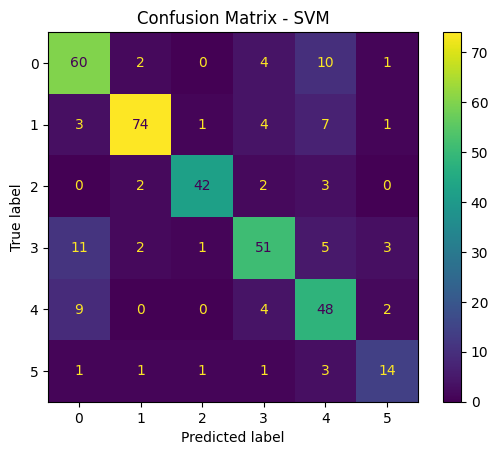

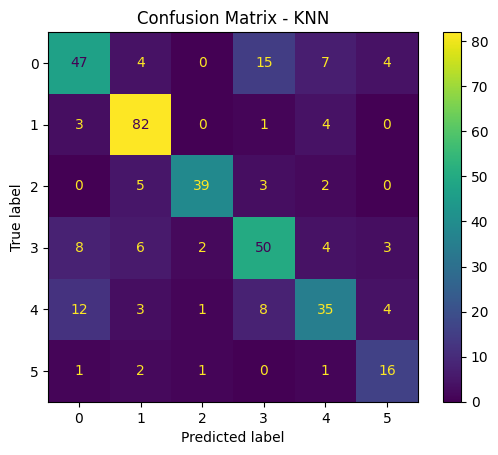

In [180]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# =========================
# Correlation-based feature reduction
# =========================
corr_matrix = df_features.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# choose BEST threshold (example: 0.7)
threshold = 0.85
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

X_train_red = np.delete(X_features, to_drop, axis=1)

# =========================
# Scaling
# =========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_red)

# =========================
# Models
# =========================
svc = SVC(kernel="rbf", C=5, gamma="scale")
knn = KNeighborsClassifier(n_neighbors=5)

svc.fit(X_train_scaled, train_labels)
knn.fit(X_train_scaled, train_labels)

# =========================
# Test features
# =========================
X_test_features = extractor.transform(test_files, train=False)
X_test_red = np.delete(X_test_features, to_drop, axis=1)
X_test_scaled = scaler.transform(X_test_red)

# =========================
# Predictions
# =========================
svc_preds = svc.predict(X_test_scaled)
knn_preds = knn.predict(X_test_scaled)

# =========================
# Accuracy
# =========================
print(f"SVM Test Accuracy: {accuracy_score(test_labels, svc_preds)*100:.2f}%")
print(f"KNN Test Accuracy: {accuracy_score(test_labels, knn_preds)*100:.2f}%")

# =========================
# Confusion Matrix - SVM
# =========================
cm_svc = confusion_matrix(test_labels, svc_preds)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc)
disp_svc.plot()
plt.title("Confusion Matrix - SVM")
plt.show()

# =========================
# Confusion Matrix - KNN
# =========================
cm_knn = confusion_matrix(test_labels, knn_preds)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn)
disp_knn.plot()
plt.title("Confusion Matrix - KNN")
plt.show()


In [181]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

corr_matrix = df_features.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

thresholds = np.arange(0.4, 0.95, 0.05)

print("TH | Features | SVC Train | SVC Test | KNN Train | KNN Test")
print("-"*65)

for th in thresholds:

    # ---- feature selection ----
    to_drop = [col for col in upper.columns if any(upper[col] > th)]
    X_train_red = np.delete(X_features, to_drop, axis=1)

    # ---- scaling ----
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_red)

    # ---- models ----
    svc = SVC(kernel="rbf", C=5, gamma="scale")
    knn = KNeighborsClassifier(n_neighbors=5)

    svc.fit(X_train_scaled, train_labels)
    knn.fit(X_train_scaled, train_labels)

    # ---- test features ----
    X_test_features = extractor.transform(test_files, train=False)
    X_test_red = np.delete(X_test_features, to_drop, axis=1)
    X_test_scaled = scaler.transform(X_test_red)

    # ---- predictions ----
    svc_train_acc = accuracy_score(train_labels, svc.predict(X_train_scaled))
    svc_test_acc  = accuracy_score(test_labels, svc.predict(X_test_scaled))

    knn_train_acc = accuracy_score(train_labels, knn.predict(X_train_scaled))
    knn_test_acc  = accuracy_score(test_labels, knn.predict(X_test_scaled))

    print(f"{th:.2f} | {X_train_red.shape[1]:8d} | "
          f"{svc_train_acc*100:8.2f}% | {svc_test_acc*100:8.2f}% | "
          f"{knn_train_acc*100:8.2f}% | {knn_test_acc*100:8.2f}%")


TH | Features | SVC Train | SVC Test | KNN Train | KNN Test
-----------------------------------------------------------------
0.40 |       43 |    98.79% |    68.90% |    75.45% |    60.59%
0.45 |       44 |    98.93% |    70.24% |    75.97% |    60.59%
0.50 |       49 |    99.14% |    73.73% |    77.47% |    65.42%
0.55 |       51 |    99.14% |    74.80% |    78.73% |    65.95%
0.60 |       53 |    99.14% |    75.60% |    80.09% |    70.78%
0.65 |       57 |    99.36% |    77.48% |    80.75% |    71.05%
0.70 |       59 |    99.48% |    77.75% |    80.68% |    71.31%
0.75 |       60 |    99.41% |    77.75% |    81.35% |    71.85%
0.80 |       60 |    99.41% |    77.75% |    81.35% |    71.85%
0.85 |       61 |    99.38% |    77.48% |    81.37% |    72.12%
0.90 |       63 |    99.38% |    77.75% |    81.63% |    72.39%


In [163]:
# drop correlated features
corr_matrix = df_features.corr().abs()
#the next line gets the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]
X_features_reduced = np.delete(X_features, to_drop, axis=1)
print("Reduced feature vector shape:", X_features_reduced.shape)

Reduced feature vector shape: (4207, 26)


In [164]:
# X_features=X_features_reduced

In [165]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_features)


In [166]:
svc = SVC(kernel="rbf", C=5, gamma="scale")
svc.fit(X_train, train_labels)
print("SVC Training completed")

SVC Training completed


In [167]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, train_labels)
print("KNN Training completed")

KNN Training completed


In [168]:
# Extract features from test files
X_test_features = extractor.transform(test_files,train=False)
#X_test_features = x_test_features by deleting correlated features
# X_test_features=np.delete(X_test_features, to_drop, axis=1)
X_test_features = scaler.transform(X_test_features)
print("Test feature extraction completed.")

# svc train accuracy
svc_train_preds = svc.predict(X_train)
svc_train_acc = accuracy_score(train_labels, svc_train_preds)
print(f"SVC Train Accuracy: {svc_train_acc*100:.2f}%")

#svc
svc_preds = svc.predict(X_test_features)
svc_acc = accuracy_score(test_labels, svc_preds)
print(f"SVC Test Accuracy: {svc_acc*100:.2f}%")



#knn train accuracy
knn_train_preds = knn.predict(X_train)
knn_train_acc = accuracy_score(train_labels, knn_train_preds)
print(f"KNN Train Accuracy: {knn_train_acc*100:.2f}%")

#knn
knn_preds = knn.predict(X_test_features)
knn_acc = accuracy_score(test_labels, knn_preds)
print(f"KNN Test Accuracy: {knn_acc*100:.2f}%")

Test feature extraction completed.
SVC Train Accuracy: 94.37%
SVC Test Accuracy: 74.46%
KNN Train Accuracy: 84.34%
KNN Test Accuracy: 72.14%


# anther try